# <span style='color:blue'> LENDING CLUB CASE STUDY </span>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<span style='color:black'> Shrinivas Bhat </span>

***
***

## Problem Statement

#### Business Understanding
   - Lending club has 2 main Functions
       1. Providing the borrowers a way to apply for the loan
       2. Having a environment for investors to fund these loans.
   - There are 3 Parties invloved in the lending club
       1. Borrower - Who applies for a loan for the specific purpose
       2. Lending Club - Based on the category,purpose,grades,sub-grades..etc approves the loan amount which may be less than or equal to the applied loan from the borrower.
       3. Investor - Who decides to invest in the specific loan portfolio's with various risk categories. Investor may decide on investing in the loan amount equal to or less than the approved loan amount from the lending club.

   - If the company approves the loan, there are 3 possible scenarios described below
        1. Fully paid: Applicant has fully paid the loan (the principal and the interest rate)
        2. Current: Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'.
        3. Charged-off: Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan 
       
   

   - There may be specific schemes/guidelines for these loans which may vary across lending club.(Out of scope currently but to ponder in future)
       1. There may be a minimum amount specified to an investor to fund the loan.
       2. Each funded portfolio (indicated funded_amnt_inv) can come from a single investor or a multiple of investors.
       3. Borrower may close the loan amount pre-maturly and this also may lead to a pre-matured closure risks to invester and lending club. It is so far not clear in the case-study on whether this pre-closure risks to be bourne by invester or lending club.
         
       
   - There are 2 types of risks associated with the Lending clubs decision
       1. If borrower is likely to repay the loan not approveing the loan results in loss of business
       2. If borrower is likely to default approving the loan will lead to financial loss both to investor and the lending club.
      
> -  Note : the customer behavior variables are not available at the time of loan application, and thus they cannot be used as predictors for credit approval.variables such as acc_now_delinquent, chargeoff within 12 months etc. (which are related to the applicant's past loans) are available from the credit bureau.

#### What is Provided
   - Information about past loan appicants and whether they defaulted or not.(loan.csv)
   - Data dictionary file which provides the description of various attributes (Data_dictionary.xls)

 
#### Goal
   - Understand the Consumer Attributes and Loan Attributes and analyse its influence on the tendency of default.The customers labelled as 'charged-off' in loan_status are the 'defaulters'. 
   - Idenfify patterns to indicate the person defaulting , which may be further used to take decisions like denying the loan,reducing the loan amount, higher interest rates to risky applicants.

#### Scope
   - Data Understanding
   - Data Cleaning 
   - Data Analysis (EDA) with  appropriate visualizations for various attributes and its influence on tendeny to default.
   - Insights , Observations and Recommendations  
   
#### References
[1] 

#### Future Work
   - Joint Probability of Multiple paremters and using across portfolio of investments to see if lending company is likely to infer loss and finetuning the interest rates,lending amount across risk categories to increase the profitability of lending club and investers.
   - Derive and maintain some sort of FICO/Vantage Scores by combining various parameters like dti, 
   - Building a Comprehensive ML Model for the  optimal lending strategy, which can classify the risky user and decide the approval,rejection and interest rates for the different loan category.




***

## Import and Data read 

In [1478]:
#Uncomment Below lines when running in Google-Colab
#from google.colab import drive
#drive.mount('/content/drive')

In [1589]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import plotly.express as px
# Uncomment Below Line when running in Google Co-lab
#loanC = pd.read_csv('/content/drive/Othercomputers/My Laptop/GDrive/MS/Project/lending_club_casestudy/loan.csv',low_memory=False)
loanC= pd.read_csv("loan.csv",low_memory=False)
loanC.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [1590]:
loanC.shape

(39717, 111)

In [1591]:
 from platform import python_version
python_version()

'3.9.12'

***

## Data Cleaning 
#### Sanity Check whether the Member ID's are repeated (Sanity Check)
   - Intention is to see if any member-id's are repeated or to filterout multiple application from a same member-id.
   - It can be seen that such duplications are not seen in the dataset.
   


In [1592]:
#(~(loanC.member_id.value_counts()==1)).sum() ## If Sum is 0 then there are no repeated values of the member_id
#loanC.member_id.value_counts() ## Alternatively the count 39717 Matches tghe total range in info
loanC.member_id.duplicated().sum()

0

####  Drop the Columns/Rows which have all NA's

   - Many Columns Dropped(111 Columns to 57 Columns)


In [1593]:
LCLoanDf = loanC.dropna(axis=1,how='all')
LCLoanDf = LCLoanDf.dropna(axis=0,how='all')
LCLoanDf.shape

(39717, 57)

In [1594]:
#Columns not having na
LCLoanDf[~(LCLoanDf.isna().any(axis=1)==True)].shape

(14, 57)

####  Remove the columns which has only one value
    - Columns dropped from 57 to 48

> Note : Columns with a one Valid value and NA is still treated as a single value columns

In [1595]:
LCLoanDf = LCLoanDf.loc[:,list(map(lambda x : False if LCLoanDf[x].value_counts().size==1 else True , list(LCLoanDf)))] #remove single value columns
LCLoanDf.shape


(39717, 48)

#### Cleaning up of Public recorded bankruptsies 
   - Replace NaN from this record to zero (Assume that those members are not bankrupt)

In [1596]:
LCLoanDf.loc[(LCLoanDf.pub_rec_bankruptcies.isna()==True),"pub_rec_bankruptcies"] = 0
LCLoanDf.loc[(LCLoanDf.pub_rec_bankruptcies.isna()==True)]
LCLoanDf["pub_rec_bankruptcies"].value_counts()

0.0    38036
1.0     1674
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [1597]:
LCLoanDf.shape

(39717, 48)

####  Study of the Correlation between various columns to check whether any columns can be removed.
   - Corrleated if found can be removed


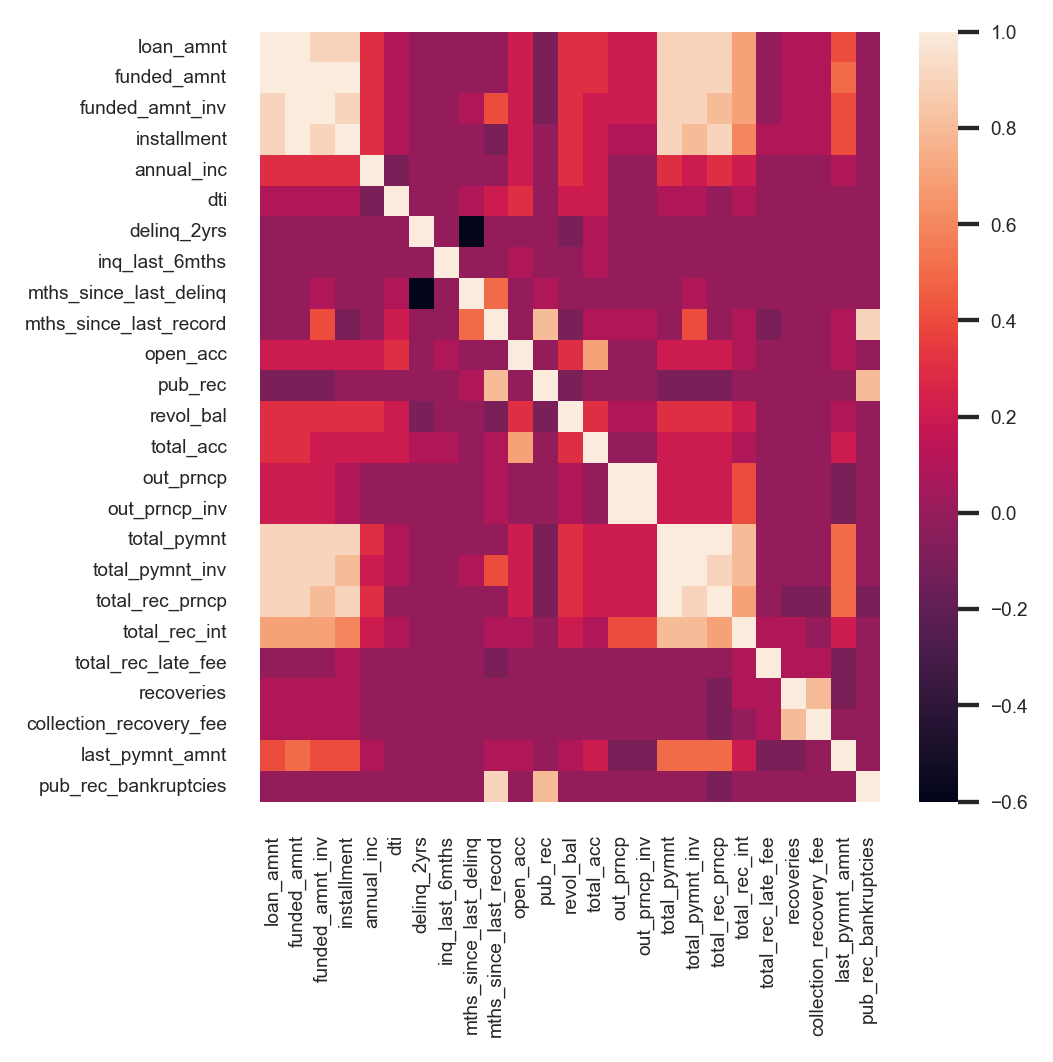

In [1599]:
import plotly.express as px
from matplotlib.pyplot import figure
figure(figsize=(4,4), dpi=250)
LCLoanDfCor = LCLoanDf.iloc[:,2:].corr().round(1)
sb.set(font_scale=0.5)
plt.xticks(rotation=0)
#LCLoanDfCor.style.background_gradient(cmap='PuBu')
sb.heatmap(LCLoanDf.iloc[:,2:].corr().round(1),annot=False)
sb.set(font_scale=1)

#### Dropping Certain Colums which add least value in the Analysis
- Unneccesary Columns 'desc','url'
- Columns like emp_title,title is removed as they dont seem to influence the tendency of default.
- zip code also can be removed as they also dont seem to infulence the borrowers tendency to default.
- Drop Corrlelated Columns 
- Also for the new customer's the columns which signify the customer behaviour variables is assumed to be not available and hence cannot be used in the model. Hence from the data we will remove those data. 
- Columns reduced to only 19

> ######    <span style='color:Red'> Caveats </span>
> - It is assumed that the Customer behaviour variables like 'delinq_2yrs','open_acc','pub_rec',..etc   are not available. Is it a valid assumption as since these may be availble publicly for that customer with his relationhip with other banks or lending agencies ? Many of these variables can be used to however derive FICO Scores which can be looked as an extended project. 

> - The Behavioural variables are distributed into two categories
>      1. The general behaviourial category which may come as public records 
>      2. Lending club specific behavioural columns which may not be known for the new customer.

> - BorrowBehCol_Gen = [ 'delinq_2yrs','earliest_cr_line','inq_last_6mths',
'mths_since_last_delinq'              'mths_since_last_record','open_acc','pub_rec','revol_bal',
'revol_util','total_acc' ] Ideally it would be better to convert these general Behavourial category variables into a FICO/Vantage Scores. 

> - BorrowBehCol_Len = [ 'out_prncp','out_prncp_inv','total_pymnt',                'total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee'                'recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt'                'next_pymnt_d','last_credit_pull_d','pub_rec_bankruptcies' ]

              



In [1488]:
# Borrowers General Behavioural Columns
BorrowBehCol_Gen = ['delinq_2yrs','earliest_cr_line','inq_last_6mths','mths_since_last_delinq',\
               'mths_since_last_record','open_acc','pub_rec','revol_bal',\
               'revol_util','total_acc']
# Borrowers Behavioural Columns for this Lending Club
BorrowBehCol_Len = ['out_prncp','out_prncp_inv','total_pymnt',\
               'total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee',\
               'recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',\
               'next_pymnt_d','last_credit_pull_d','pub_rec_bankruptcies']
## Drop LendingClub Specific Behavioural Columns
LCLoanDf.drop(columns = BorrowBehCol_Len, inplace = True)
## Oher unnecessary columns
LCLoanDf.drop(columns = [ 'emp_title', 'url', 'desc', 'title'], inplace = True)
## For "out of curiosity" section consdering general behavioural section
LCLoanDf_ooc = LCLoanDf.copy(deep=True);
## Drop General Behavioural Columns
LCLoanDf.drop(columns = BorrowBehCol_Gen, inplace = True)
# Drop Correlated Columns (fundedn_amnt - there are many but they are elminated in behavioral columns)
LCLoanDf.drop(columns = [ 'funded_amnt'], inplace = True)
LCLoanDf.shape

(39717, 19)

In [1489]:
LCLoanDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   39717 non-null  int64  
 1   member_id            39717 non-null  int64  
 2   loan_amnt            39717 non-null  int64  
 3   funded_amnt_inv      39717 non-null  float64
 4   term                 39717 non-null  object 
 5   int_rate             39717 non-null  object 
 6   installment          39717 non-null  float64
 7   grade                39717 non-null  object 
 8   sub_grade            39717 non-null  object 
 9   emp_length           38642 non-null  object 
 10  home_ownership       39717 non-null  object 
 11  annual_inc           39717 non-null  float64
 12  verification_status  39717 non-null  object 
 13  issue_d              39717 non-null  object 
 14  loan_status          39717 non-null  object 
 15  purpose              39717 non-null 

***
***

## Data Manipulations and Post-processing


####  Employee Experience (Employment Length) post processing

   - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years as specified in "RejectStats" of "DataDictionary.xlsx"



In [1490]:
LCLoanDf.emp_length.astype('str').apply(lambda x: x[0:2] if (x[0:3] == '10+') else x).value_counts()#.apply(lambda x: 0 if (x[0] == '<') else x[0]).value_counts()
LCLoanDf.emp_length.astype('str').value_counts()
# Experience Length capped to 10 and 0 
LCLoanDf.emp_length = LCLoanDf.emp_length.astype('str').apply(lambda x: x[0:2] if (x[0:3] == '10+') else x).apply(lambda x: 0 if (x[0] == '<') else x).replace(regex = 'years',value = '').replace(regex = 'year',value = '').replace(to_replace='nan',value='0').astype("int32")
LCLoanDf.emp_length.value_counts()

10    8879
0     5658
2     4388
3     4095
4     3436
5     3282
1     3240
6     2229
7     1773
8     1479
9     1258
Name: emp_length, dtype: int64

#### Remove % from Interest Rates (Post-Processed Interest rates)
   - Creating a postprocessed interest rate column (int_rate_pp)



In [1491]:
LCLoanDf["int_rate_pp"] = LCLoanDf.int_rate.apply(lambda x:  x[:-1]).astype("float32")

#### Post-Processing Zip-Code Column
   - Create a postprocessed zip code as per the RejectStats Column requirement

In [1492]:
#Converting zip code to numeric
LCLoanDf["zip_code_n"] = LCLoanDf.zip_code.apply(lambda x: x[0:3]).astype("int32")
#LCLoanDf.zip_code.plot.hist(bins=100,figsize = [5,3])
plt.show()
LCLoanDf.zip_code_n.value_counts()
#LCLoanDf.zip_code_n.plot.hist()

100    597
945    545
112    516
606    503
70     473
      ... 
381      1
378      1
739      1
396      1
469      1
Name: zip_code_n, Length: 823, dtype: int64

#### Creation of Ratio of approved Invested amount to Loan amount
- A new field indicating the percentage of loan approved from the investor towards. (ratio of funded_amnt_inv to loan_amount)


In [1493]:
LCLoanDf["funded_loan_perc"] = LCLoanDf.funded_amnt_inv/ LCLoanDf.loan_amnt *100
LCLoanDf["funded_loan_perc"] = LCLoanDf["funded_loan_perc"].round(0)
LCLoanDf["funded_loan_perc"] 

0        100.0
1        100.0
2        100.0
3        100.0
4        100.0
         ...  
39712     43.0
39713     10.0
39714     26.0
39715     13.0
39716     11.0
Name: funded_loan_perc, Length: 39717, dtype: float64

#### Creation of a Annual Income Category from the continuos variable

In [1494]:
LCLoanDf["annual_inc_cat"]=pd.cut(LCLoanDf.annual_inc,bins=[0,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,100000,150000],labels=['<=5K','>5K<=10K','>10K<=15K','>15K<=20K',\
                                                                                                                                                '>20K<=25K','>25K<=30K','>30K<=35K',\
                                                                                                                                                '>35K<=40K','>40K<=45K','>45K<=50K','>50K<=100K',\
                                                                                                                                                '>100K'])
LCLoanDf["annual_inc_cat"].value_counts()

>50K<=100K    18286
>100K          4136
>35K<=40K      3201
>45K<=50K      3056
>40K<=45K      2811
>30K<=35K      2052
>25K<=30K      2048
>20K<=25K      1387
>15K<=20K       691
>10K<=15K       399
>5K<=10K         89
<=5K             10
Name: annual_inc_cat, dtype: int64

#### Creation of a Interest  Category from the continuos variable

In [1495]:
LCLoanDf["int_rate_cat"]=pd.cut(LCLoanDf.int_rate_pp,bins=[0,5,10,15,20,25],labels=['<5%','5% to 10%','10% to 15%','15% to 20%','20% to 25%'])
LCLoanDf["int_rate_cat"].value_counts()

10% to 15%    18794
5% to 10%     12393
15% to 20%     7658
20% to 25%      872
<5%               0
Name: int_rate_cat, dtype: int64

#### Creation of a DTI  Category from the continuos variable

In [1496]:
LCLoanDf["dti_cat"]=pd.cut(LCLoanDf.dti,bins=[5,10,15,20,25],labels=['5% to 10%','10% to 15%','15% to 20%','20% to 25%'])
LCLoanDf["dti_cat"].value_counts()

10% to 15%    9899
15% to 20%    9095
5% to 10%     8072
20% to 25%    6815
Name: dti_cat, dtype: int64

In [1497]:
# LCLoanDf.mths_since_last_delinq.describe()
# LCLoanDf.verification_status.value_counts()
# LCLoanDf.mths_since_last_record.describe()
# LCLoanDf.loan_status.value_counts()
# LCLoanDf.dti.describe()
# LCLoanDf.pub_rec.value_counts()
# LCLoanDf.purpose.value_counts()
# LCLoanDf.delinq_2yrs.value_counts()  #The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
# #A delinquency is a late payment.The consequences of a delinquency can be severe when it comes to your credit score.
# LCLoanDf.mths_since_last_record.value_counts()

In [1498]:
#LCLoanDf.emp_length.isna().sum()


#### Converting the Ordinal Variable Grade/Subgrade,loan_status to Numeric Variable
   - Grade and Subgrades are maped to Numeric Variables with a new columns sub_grade_n and grade_n
   - loan_defaulted = 1 (Charged-off) = 0 (Otherwise)


In [1499]:
import numpy as np
LCLoanDf['sub_grade_n']=LCLoanDf['sub_grade'].replace(LCLoanDf.sub_grade.astype('str').sort_values().unique(),np.array(range(0,35)),inplace=False)
#LCLoanDf.sub_grade_n.plot.hist(bins=35,figsize=[5,3])
plt.show()
LCLoanDf['grade_n']=LCLoanDf['grade'].replace(LCLoanDf.grade.astype('str').sort_values().unique(),np.array(range(0,7)),inplace=False)
#LCLoanDf.grade_n.plot.hist(bins=7,figsize = [5,3])
plt.show()
## Loan Defaulted Column based on Chargedoff or Otherwise
LCLoanDf["loan_defaulted"] =  LCLoanDf.loan_status.apply(lambda x: 1 if (x=="Charged Off") else 0 )

#### Relook @ Correlation Plot of Final Reduced data-set

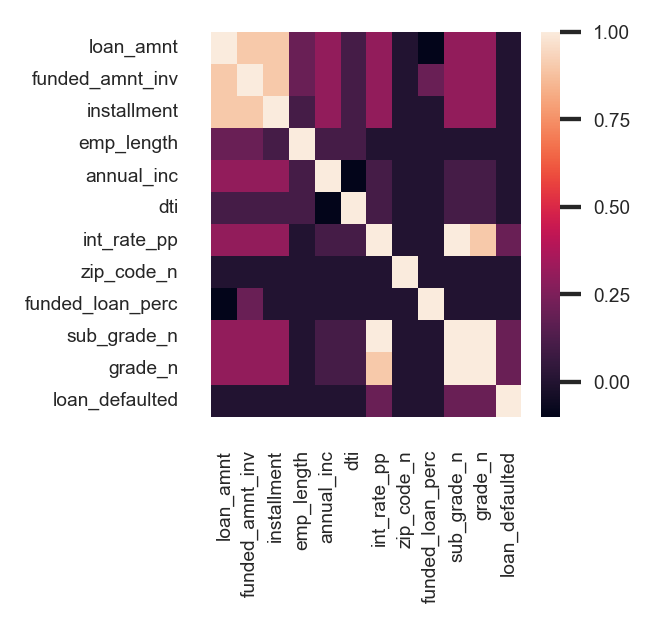

In [1500]:
import plotly.express as px
from matplotlib.pyplot import figure
figure(figsize=(2,2), dpi=250)
LCLoanDfCor = LCLoanDf.iloc[:,2:].corr().round(1)
sb.set(font_scale=0.5)
plt.xticks(rotation=0)
#LCLoanDfCor.style.background_gradient(cmap='PuBu')
sb.heatmap(LCLoanDf.iloc[:,2:].corr().round(1),annot=False)
sb.set(font_scale=1)

### Insights
- grade and subgrade have strong correlation
- Weak   correlation seen between loan defaulted interest rates,grades/subgrades
- Some correlation seen between the annual income with loan amount,funded amount and installment.

***

## Exploratory Data Analysis


### Univariate and Segmented Univariate Analysis

#### Rank-Frequency Analysis of the loan Amount

<AxesSubplot:ylabel='loan_amnt'>

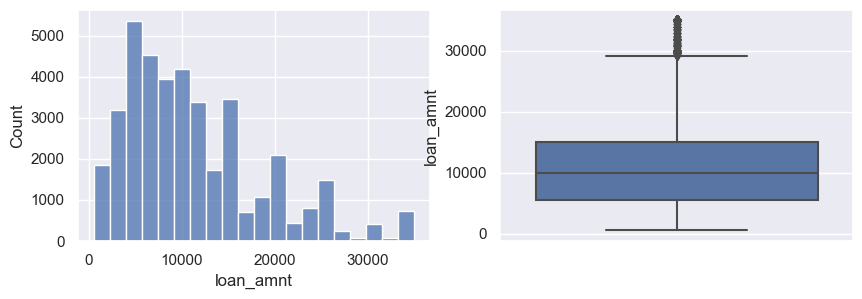

In [1501]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sb.histplot(LCLoanDf.loan_amnt,ax=axes[0],bins=20)
sb.boxplot(ax=axes[1],x=None,y=LCLoanDf.loan_amnt)

#### Rank-Frequency plot for Debt-to-income ratio


<AxesSubplot:ylabel='dti'>

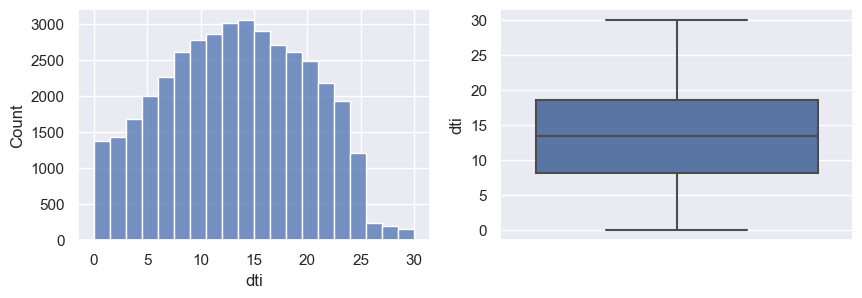

In [1502]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sb.histplot(LCLoanDf.dti,ax=axes[0],bins=20)
sb.boxplot(ax=axes[1],x=None,y=LCLoanDf.dti)

####  Rank-Frequency for empl-length


<AxesSubplot:ylabel='emp_length'>

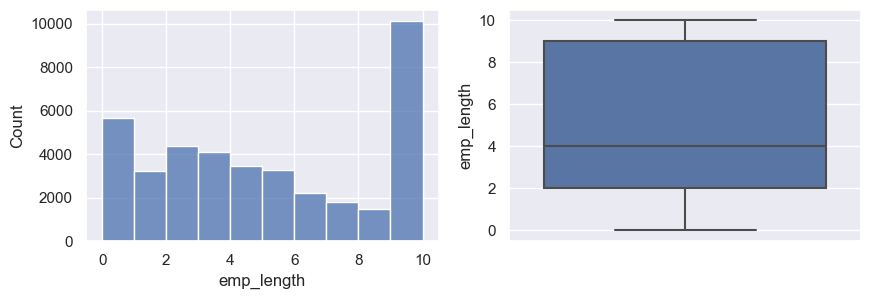

In [1503]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sb.histplot(LCLoanDf.emp_length,ax=axes[0],bins=10)
sb.boxplot(ax=axes[1],x=None,y=LCLoanDf.emp_length)


####  Rank-Frequency for grades and sub-grades


<AxesSubplot:xlabel='sub_grade', ylabel='Count'>

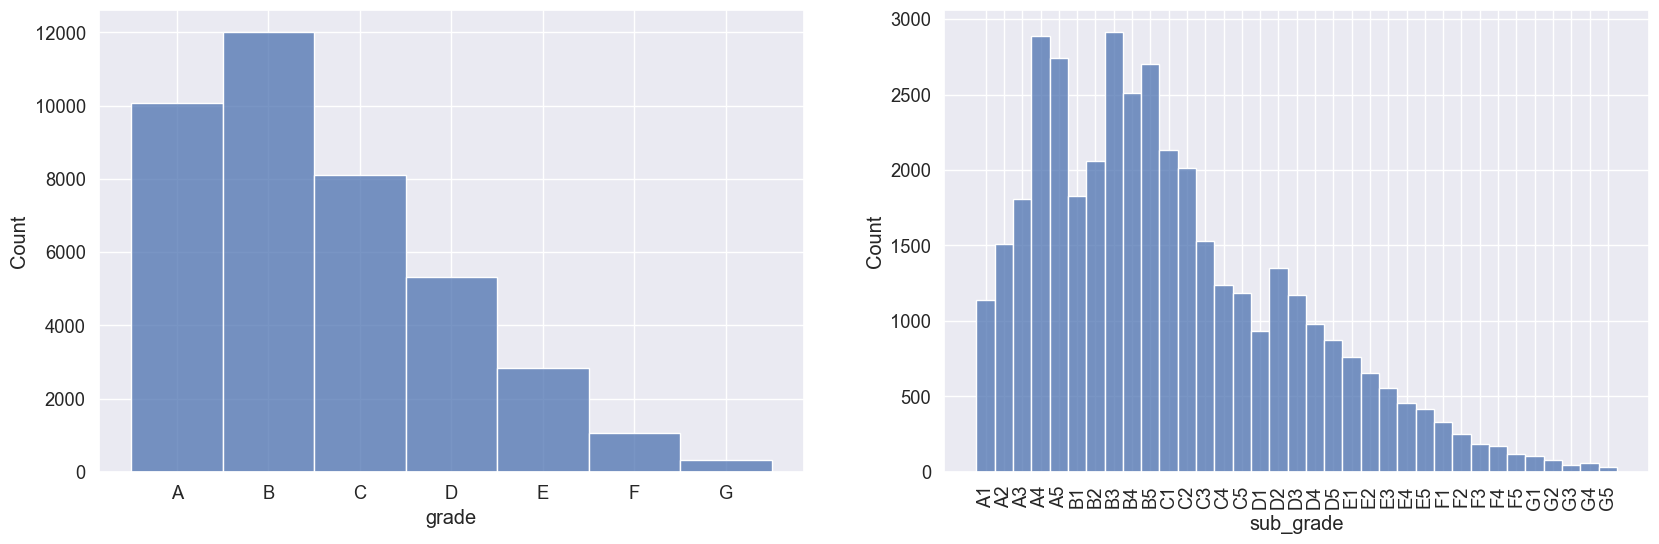

In [1608]:
sb.set(font_scale=1.2)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plt.xticks(rotation=90)
sb.histplot(LCLoanDf.grade.sort_values(),ax=axes[0],bins=10)
sb.set(font_scale=1.2)
sb.histplot(LCLoanDf.sub_grade.sort_values(),ax=axes[1],bins=10)


- Looking at the cumulative inclusion of grades (90% borrowers are within D,96% within E and 99% with F)

In [1505]:
LCLoanDf.grade.value_counts().cumsum()/39717*100


B     30.264119
A     55.656268
C     76.045522
D     89.407558
E     96.563185
F     99.204371
G    100.000000
Name: grade, dtype: float64

#### Rank-Frequency for Interest rates


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='int_rate'>

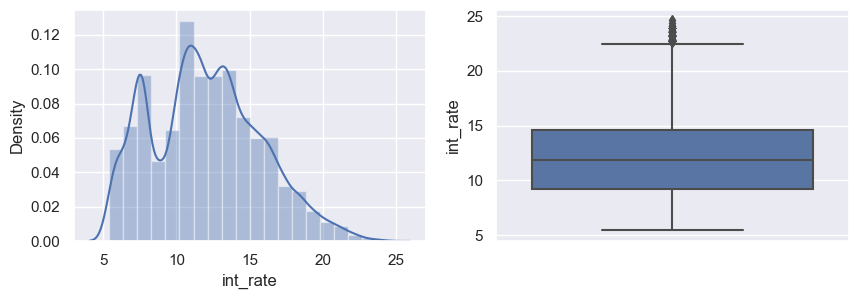

In [1600]:
sb.set(font_scale=1)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sb.distplot(LCLoanDf.int_rate.apply(lambda x:  x[:-1]).astype("float32"),ax=axes[0],bins=20)
#sb.histplot(LCLoanDf.grade.sort_values(),ax=axes[1],bins=20)
sb.boxplot(ax=axes[1],x=None,y=LCLoanDf.int_rate.apply(lambda x:  x[:-1]).astype("float32"))


#### Rank-Frequency plot for %loan approved from investor


100.0    25239
99.0      3939
98.0      2233
97.0       936
96.0       695
         ...  
31.0        20
41.0        19
44.0        19
33.0        18
1.0         17
Name: funded_loan_perc, Length: 101, dtype: int64

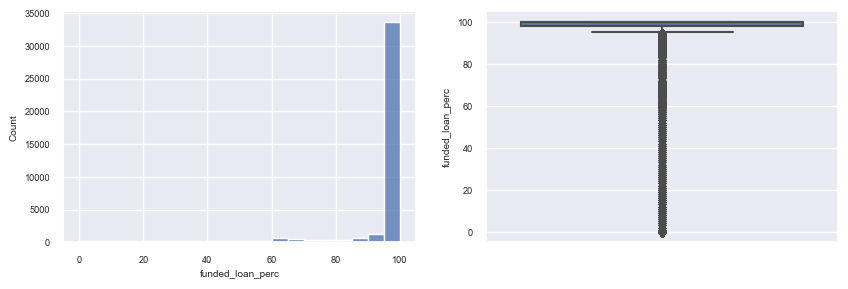

In [1507]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sb.histplot(LCLoanDf.funded_loan_perc,ax=axes[0],bins=20)
sb.boxplot(ax=axes[1],x=None,y=LCLoanDf.funded_loan_perc)
LCLoanDf.funded_loan_perc.value_counts()

#### Rank-Frequency for Installment


<AxesSubplot:ylabel='installment'>

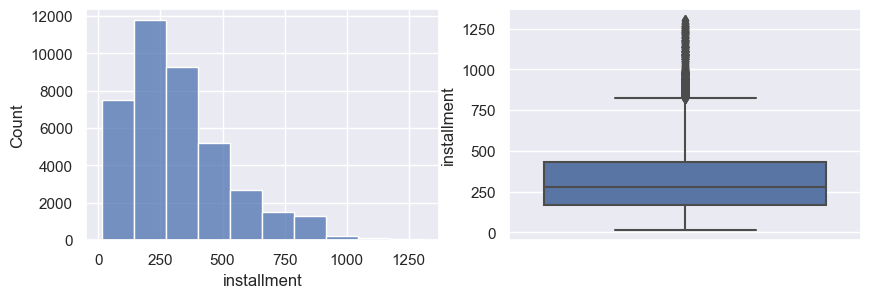

In [1601]:
sb.set(font_scale=1)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
plt.xticks(rotation=90)
sb.histplot(LCLoanDf.installment.sort_values(),ax=axes[0],bins=10)
sb.boxplot(ax=axes[1],x=None,y=LCLoanDf.installment)


#### Rank-Frequency for Annual Income
- box plot isnt clear and it clearly shows huge outliers 
- caping to 0.15e06 in the annual income is reasonable for analysis as most data lies in that range


<AxesSubplot:ylabel='annual_inc'>

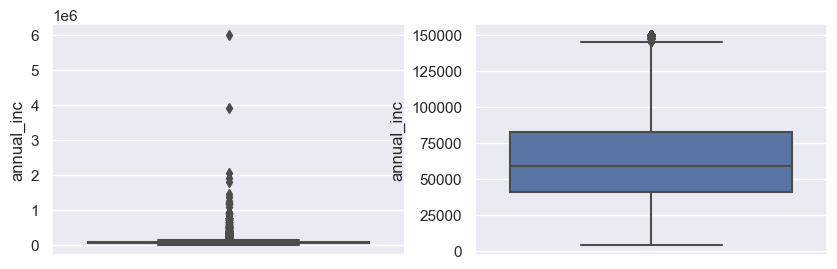

In [1602]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
#sb.histplot(LCLoanDf.grade.sort_values(),ax=axes[1],bins=20)
sb.boxplot(ax=axes[0],x=None,y=LCLoanDf.annual_inc)
#LCLoanDf[LCLoanDf.annual_inc>0.15e06].annual_inc.value_counts().sum()
LCLoanDf.loc[LCLoanDf.annual_inc>0.15e06,"annual_inc"] = 0.15e06
#sb.histplot(LCLoanDf.grade.sort_values(),ax=axes[1],bins=20)
sb.boxplot(ax=axes[1],x=None,y=LCLoanDf.annual_inc)

  - Default annual income box plot                        
                                                        - After Capping the annual income to 150K$


#### Statistics of all Numeric Columns


In [1510]:
LCLoanDf.drop(columns=['id','member_id','zip_code_n','sub_grade_n','grade_n','loan_defaulted']).describe().round(2)

,loan_amnt,funded_amnt_inv,installment,emp_length,annual_inc,dti,int_rate_pp,funded_loan_perc
count,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00
mean,11219.44,10397.45,324.56,4.84,65469.93,13.32,12.02,93.90
std,7456.67,7128.45,208.87,3.61,33256.90,6.68,3.72,17.16
min,500.00,0.00,15.69,0.00,4000.00,0.00,5.42,0.00
25%,5500.00,5000.00,167.02,2.00,40404.00,8.17,9.25,98.00
50%,10000.00,8975.00,280.22,4.00,59000.00,13.40,11.86,100.00
75%,15000.00,14400.00,430.78,9.00,82300.00,18.60,14.59,100.00
max,35000.00,35000.00,1305.19,10.00,150000.00,29.99,24.59,100.00


### Insights 
- Annual income of borrowers around the median value of around 60K with a spread between 40K and 82K
- Professional experience or employee length of most of the borrowers is about 4 Years.
- Monthly installment for the borrower has a median value of 280 dollars and spread between 167 to 430 dollars.
- Applied Loan amount from the borrower has meduan value of 10K and spread between 5.5K and 15K dollars.
- Funded amount for the invester is about 9K and spread between 5K to 14.4K.
- Interest rates for the borrowed amount is at median value of 11.86% and spread between 9.25% to 24.6%
- From the grade distribution of the borrowers 90% of borrowers fall  within grade D.


***
***
***

### BiVariate Analysis

#### Analysis of loan Amount to the borrowers tendency to default


In [1511]:
#### Rank-Frequency Analysis of the loan Amount
LCLoanDf.loan_amnt.describe()

count    39717.000000
mean     11219.443815
std       7456.670694
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

loan_amnt_cat      <5K   >5K<10K  >10K<15K  >15K<20K  >20K<25K  >25K<30K  \
loan_status                                                                
Charged Off    1314.00   1642.00   1055.00    751.00    542.00    143.00   
Current          96.00    158.00    303.00    242.00    163.00     85.00   
Fully Paid     8158.00  11160.00   6628.00   3598.00   2294.00    557.00   
All            9568.00  12960.00   7986.00   4591.00   2999.00    785.00   
Prob_Def          0.02      0.02      0.02      0.02      0.02      0.02   

loan_amnt_cat    >30K       All  
loan_status                      
Charged Off    180.00   5627.00  
Current         93.00   1140.00  
Fully Paid     555.00  32950.00  
All            828.00  39717.00  
Prob_Def         0.03      0.14  


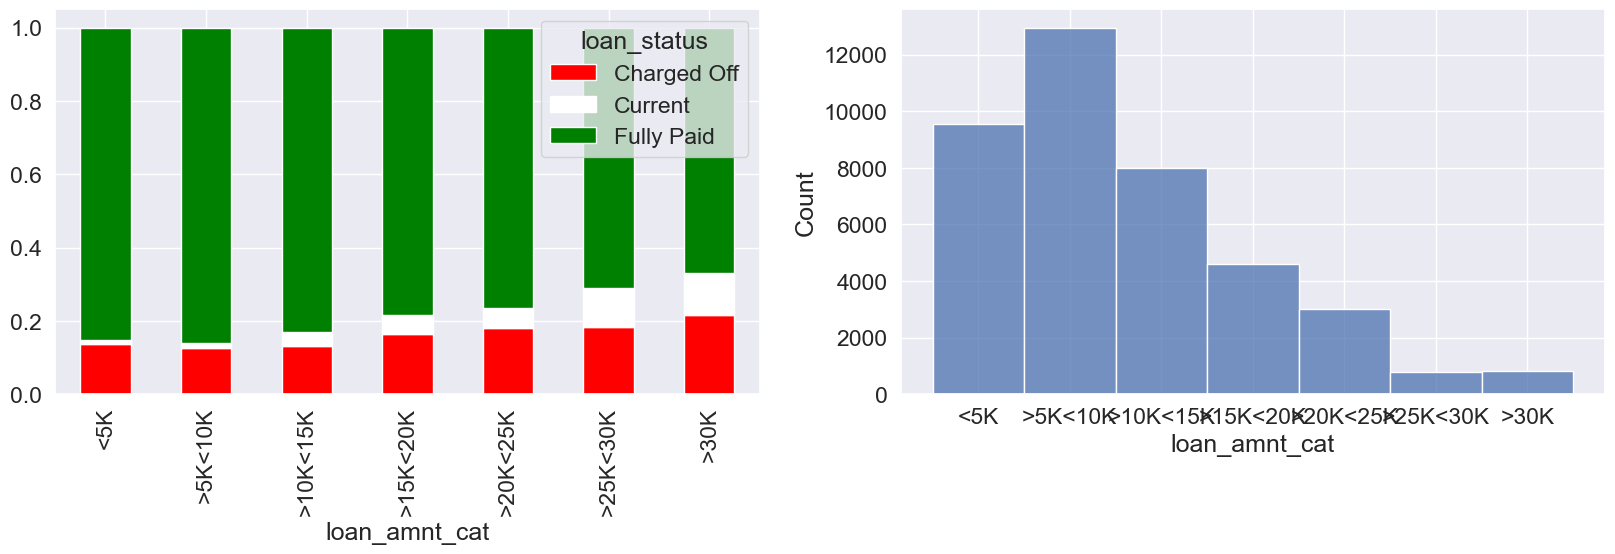

In [1512]:
LCLoanDf["loan_amnt_cat"]=pd.cut(LCLoanDf.loan_amnt,bins=[0,5000,10000,15000,20000,25000,30000,50000],labels=['<5K','>5K<10K','>10K<15K','>15K<20K','>20K<25K','>25K<30K','>30K'])
#LCLoanDf_ooc["total_acc_cat"].value_counts()

Tbl_Gen = pd.crosstab(LCLoanDf_ooc.loan_status, LCLoanDf["loan_amnt_cat"], margins=True,     values=LCLoanDf_ooc["loan_status"], aggfunc='count').round(2)
Tbl_Gen.loc["Prob_Def",:] = Tbl_Gen.loc["Charged Off",:]/Tbl_Gen.loc["All",:]
Tbl_Gen.iloc[4,:-1] = Tbl_Gen.iloc[4,:-1]/Tbl_Gen.iloc[4,:-1].sum()*Tbl_Gen.loc["Prob_Def","All"]
Tbl_Gen.loc["Prob_Def",:]  = Tbl_Gen.loc["Prob_Def",:].round(2)
Tbl_Gen = Tbl_Gen.fillna(0)
print(Tbl_Gen.head().round(2))
sb.set(font_scale=1.5)
Tbl_Gen_perc = Tbl_Gen.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_Gen_perc.plot(ax=axes[0],kind="bar", stacked="True",color=['red','white','green'])
sb.histplot(LCLoanDf.loan_amnt_cat,ax=axes[1],bins=20)
plt.show()


***

#### Analysis of loan term to the borrowers tendency to default


term          36 months   60 months        All
loan_status                                   
Charged Off    3227.000    2400.000   5627.000
Current           0.000    1140.000   1140.000
Fully Paid    25869.000    7081.000  32950.000
All           29096.000   10621.000  39717.000
Prob_Def          0.047       0.095      0.142


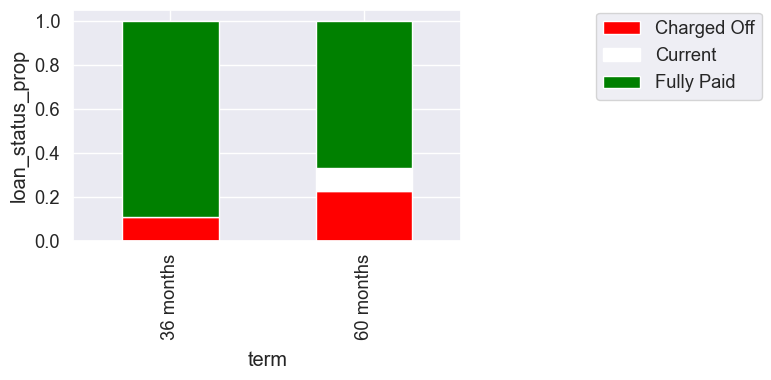

In [1609]:
#LC1b_TermvsLS = LCLoanDf.filter(items =["term","loan_status"] )
TblTermvsLS = pd.crosstab(LCLoanDf.loan_status, LCLoanDf["term"], margins=True,values=LCLoanDf["loan_status"], aggfunc='count').round(2)
TblTermvsLS.loc["Prob_Def",:] = TblTermvsLS.loc["Charged Off",:]/TblTermvsLS.loc["All",:]
TblTermvsLS.iloc[4,:-1] =TblTermvsLS.iloc[4,:-1]/TblTermvsLS.iloc[4,:-1].sum()*TblTermvsLS.loc["Prob_Def","All"]
TblTermvsLS.fillna(0,inplace=True)
print(TblTermvsLS.round(3).head())
TblTermvsLS_perc = TblTermvsLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
TblTermvsLS_perc.plot(kind="bar", stacked="True", figsize=[5,3],color=['red','white','green'])
plt.ylabel("loan_status_prop")
plt.legend(bbox_to_anchor=(1.8, 0.8),loc='right')
plt.show()

#### Insights
- Its can be seen that there is a strong dependency between the loan term and the tendency to default.
- The borrowers of 60 months loan term are twice likely to default compared to the ones with 36 months loan term. 

***


#### Analysis of Annual-income to the Borrowers tendency to default
- Does the annual income  has any dependency on the tendency of defaulting

annual_inc_cat    <=5K  >5K<=10K  >10K<=15K  >15K<=20K  >20K<=25K  >25K<=30K  \
loan_status                                                                    
Charged Off      2.000    18.000    101.000    116.000    251.000    351.000   
Current          0.000     1.000      2.000      6.000     17.000     47.000   
Fully Paid       8.000    70.000    296.000    569.000   1119.000   1650.000   
All             10.000    89.000    399.000    691.000   1387.000   2048.000   
Prob_Def         0.014     0.014      0.018      0.012      0.013      0.012   

annual_inc_cat  >30K<=35K  >35K<=40K  >40K<=45K  >45K<=50K  >50K<=100K  \
loan_status                                                              
Charged Off       347.000    565.000     416.00     446.00    2422.000   
Current            42.000     64.000      82.00      94.00     579.000   
Fully Paid       1663.000   2572.000    2313.00    2516.00   15285.000   
All              2052.000   3201.000    2811.00    3056.00   18286.00

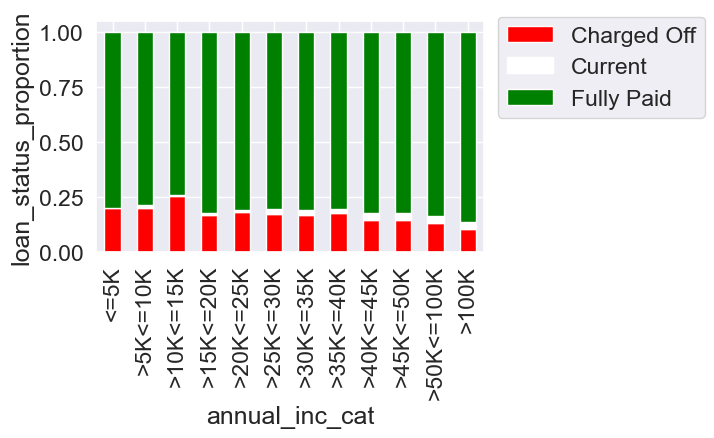

In [1514]:
#LC1b_AnualIncvsLS = LCLoanDf.filter(items =["annual_inc_cat","loan_status"] )
TblAIvsLS = pd.crosstab(LCLoanDf.loan_status, LCLoanDf["annual_inc_cat"], margins=True,values=LCLoanDf["loan_status"], aggfunc='count').round(2)
TblAIvsLS.loc["Prob_Def",:] = TblAIvsLS.loc["Charged Off",:]/TblAIvsLS.loc["All",:]
TblAIvsLS.iloc[4,:-1] =TblAIvsLS.iloc[4,:-1]/TblAIvsLS.iloc[4,:-1].sum()*TblAIvsLS.loc["Prob_Def","All"]
TblAIvsLS.fillna(0,inplace=True)
print(TblAIvsLS.round(3))
print(TblAIvsLS.iloc[4,:-1].sum().round(2))
TblAIvsLS_perc = TblAIvsLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
TblAIvsLS_perc.plot(kind="bar", stacked="True", figsize=[5,3],color=['red','white','green'])
plt.ylabel("loan_status_proportion")
plt.legend(bbox_to_anchor=(1.6, 0.8),loc='right')
plt.show()

#### Insights
- Borrowers with annual income between 10K to 15K have highest likelyhood of defaulting the loan.
- Borrowers likelyhood of defaulting reduces when the annual income crosses 40K

***

#### Analysis of Debt-to-Income Ratio to the Borrowers tendency to default


In [1515]:
LCLoanDf.dti_cat.describe()

count          33881
unique             4
top       10% to 15%
freq            9899
Name: dti_cat, dtype: object

dti_cat      5% to 10%  10% to 15%  15% to 20%  20% to 25%        All
loan_status                                                          
Charged Off   1005.000    1402.000    1389.000    1118.000   4914.000
Current        199.000     269.000     284.000     237.000    989.000
Fully Paid    6868.000    8228.000    7422.000    5460.000  27978.000
All           8072.000    9899.000    9095.000    6815.000  33881.000
Prob_Def         0.031       0.035       0.038       0.041      0.145
0.15


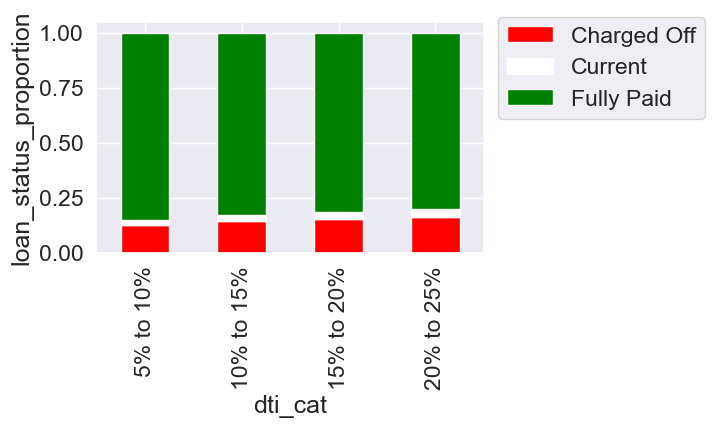

In [1516]:
#LC1b_AnualIncvsLS = LCLoanDf.filter(items =["annual_inc_cat","loan_status"] )
TblDTIvsLS = pd.crosstab(LCLoanDf.loan_status, LCLoanDf["dti_cat"], margins=True,values=LCLoanDf["loan_status"], aggfunc='count').round(2)
TblDTIvsLS.loc["Prob_Def",:] = TblDTIvsLS.loc["Charged Off",:]/TblDTIvsLS.loc["All",:]
TblDTIvsLS.iloc[4,:-1] =TblDTIvsLS.iloc[4,:-1]/TblDTIvsLS.iloc[4,:-1].sum()*TblDTIvsLS.loc["Prob_Def","All"]
TblDTIvsLS.fillna(0,inplace=True)
print(TblDTIvsLS.round(3))
print(TblDTIvsLS.iloc[4,:-1].sum().round(2))
TblDTIvsLS_perc = TblDTIvsLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
TblDTIvsLS_perc.plot(kind="bar", stacked="True", figsize=[5,3],color=['red','white','green'])
plt.ylabel("loan_status_proportion")
plt.legend(bbox_to_anchor=(1.6, 0.8),loc='right')
plt.show()

#### Insights
- There seems to be a weak trend between borrowers DTI with his tendency to default

***


#### Analysis of Interest rates to the borrowers tendency to default


int_rate_cat  <5%  5% to 10%  10% to 15%  15% to 20%  20% to 25%       All
loan_status                                                               
Charged Off   0.0     830.00     2707.00     1794.00      296.00   5627.00
Current       0.0      77.00      529.00      432.00      102.00   1140.00
Fully Paid    0.0   11486.00    15558.00     5432.00      474.00  32950.00
All           0.0   12393.00    18794.00     7658.00      872.00  39717.00
Prob_Def      0.0       0.01        0.03        0.04        0.06      0.14


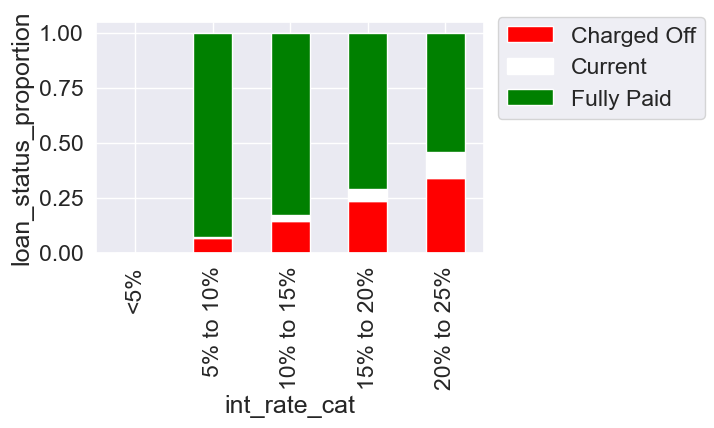

In [1517]:
#LC1b_IRvsLS = LCLoanDf.filter(items =["int_rate_cat","loan_status"] )
TblIRvsLS = pd.crosstab(LCLoanDf.loan_status, LCLoanDf["int_rate_cat"], margins=True,values=LCLoanDf["loan_status"], aggfunc='count').round(2)
TblIRvsLS.loc["Prob_Def",:] = TblIRvsLS.loc["Charged Off",:]/TblIRvsLS.loc["All",:]
TblIRvsLS.iloc[4,:-1] =TblIRvsLS.iloc[4,:-1]/TblIRvsLS.iloc[4,:-1].sum()*TblIRvsLS.loc["Prob_Def","All"]
TblIRvsLS.fillna(0,inplace=True)
print(TblIRvsLS.round(2))
TblIRvsLS_perc = TblIRvsLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
TblIRvsLS_perc.plot(kind="bar", stacked="True", figsize=[5,3],color=['red','white','green'])
plt.ylabel("loan_status_proportion")
plt.legend(bbox_to_anchor=(1.6, 0.8),loc='right')
plt.show()

#### Insights
- Loan interest rates are directly having the bearing on the tendency to default for the Borrowers
- The borrowers with interest rates >15% are more likely to default  compared to borrowers  paying below  15% interest rates

*** 

#### Analysis of the influence of  Zip-Code on the Loan_Status
- Check if the borrowers belonging to some specific zip codes are more likely to default.Considering some specific zip code's more population belonging to a specific income group (lower or higher) hence that may influence the  tendency to default.


In [1518]:
#LC1b_ZipvsLS = LCLoanDf.filter(items =["zip_code_n","loan_status"] )
TblZipvsLS = pd.crosstab(LCLoanDf.loan_status, LCLoanDf["zip_code_n"], margins=True,values=LCLoanDf["loan_status"], aggfunc='count').round(2)
TblZipvsLS.loc["Prob_Def",:] = TblZipvsLS.loc["Charged Off",:]/TblZipvsLS.loc["All",:]
TblZipvsLS.iloc[4,:-1] =TblZipvsLS.iloc[4,:-1]/TblZipvsLS.iloc[4,:-1].sum()*TblZipvsLS.loc["Prob_Def","All"]
print(TblZipvsLS.iloc[4,:-1].sum())
TblZipvsLS.fillna(0,inplace=True)
TblZipvsLS
TblZipvsLS_perc = TblZipvsLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig = px.line(data_frame=TblZipvsLS.iloc[4,:-1],title='Probalility with loan_default')
fig.show()

0.1416773673741723


#### Insights
- From the plot where the Probability is high ,The number of borrowers belonging to that specific zip codes are lower
- The area/zip code does not seem to influence the tendency to default.


***

#### Analysis of the influence of Grade on the borrowers tendency to default
- Find the relationship between two catorical variables Grade and loan status
- Find the relationship between two catorical variables Sub-Grade and loan status
- Find the Prabability of Default(Charged Off) for each Grades/Sub-Grades  

grade
A    0.005912
B    0.011741
C    0.016474
D    0.020864
E    0.024916
F    0.030117
G    0.031654
Name: Prob_Def, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

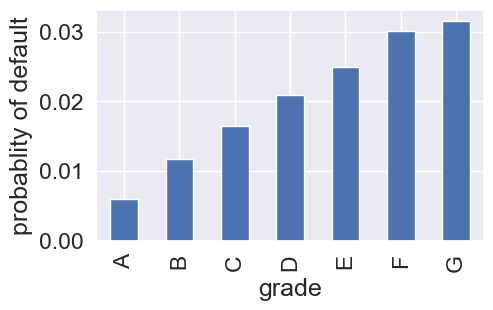

In [1519]:
#LC1b_GradevsLS = LCLoanDf.filter(items =["grade","loan_status"] )
TblGrdVersusLS = pd.crosstab(LC1b_GradevsLS.loan_status, LC1b_GradevsLS["grade"], margins=True,values=LC1b_GradevsLS["loan_status"], aggfunc='count')
TblGrdVersusLS.loc["Prob_Def",:] = TblGrdVersusLS.loc["Charged Off",:]/TblGrdVersusLS.loc["All",:]
TblGrdVersusLS.iloc[4,:-1] = TblGrdVersusLS.iloc[4,:-1]/TblGrdVersusLS.iloc[4,:-1].sum()*TblGrdVersusLS.loc["Prob_Def","All"]
print(TblGrdVersusLS.iloc[4,:-1])
TblGrdVersusLS.iloc[4,:-1].plot.bar(figsize=[5,3])
plt.ylabel("probablity of default")
plt.show

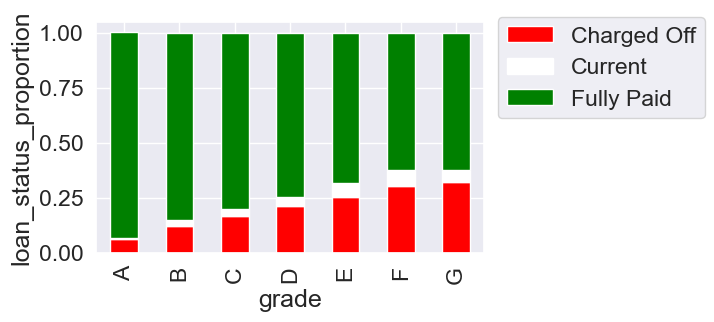

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



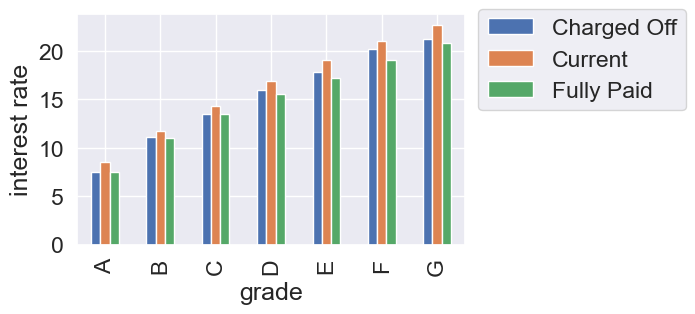

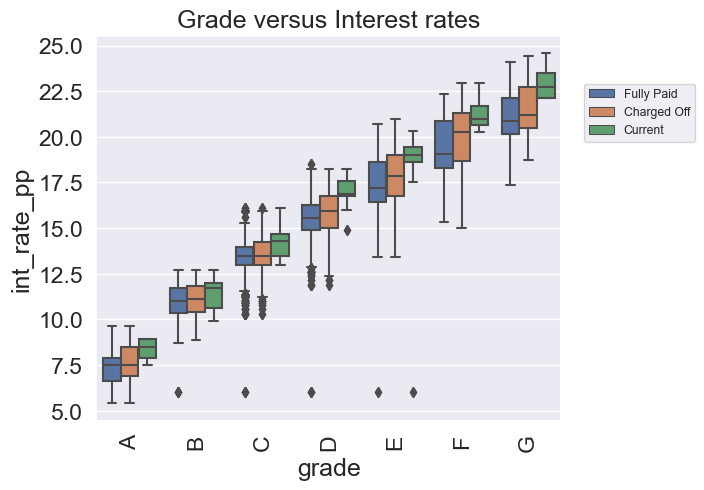

In [1520]:
TblGrdVersusLS_perc = TblGrdVersusLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
TblGrdVersusLS_perc.plot(kind="bar", stacked="True", figsize=[5,3],color=['red','white','green'])
plt.ylabel("loan_status_proportion")
plt.legend(bbox_to_anchor=(1.6, 0.8),loc='right')
plt.show()

TblGrdIntrate = pd.crosstab(LCLoanDf.int_rate.apply(lambda x:  x[:-1]).astype('float'), LCLoanDf["grade"], margins=True,     values=LCLoanDf.int_rate.apply(lambda x:  x[:-1]).astype('float'), aggfunc='mean').round(2)
TblGrdIntrate = pd.crosstab(LCLoanDf.loan_status, LCLoanDf["grade"], margins=True,values=LCLoanDf.int_rate.apply(lambda x:  x[:-1]).astype('float'), aggfunc='median').round(2)
TblGrdIntrate.iloc[:-1,:-1].transpose().plot.bar(figsize=[5,3])
plt.ylabel("interest rate")
plt.legend(bbox_to_anchor=(1.6, 0.8),loc='right')

plt.figure(figsize =(6, 5))
plt.title('Grade versus Interest rates')
plt.xticks(rotation=90)
sb.set(font_scale=0.8)
sb.boxplot('grade','int_rate_pp',data=LCLoanDf,hue ='loan_status',order=['A','B','C','D','E','F','G'])
plt.legend(bbox_to_anchor=(1.3, 0.8),loc='right')
plt.show()

In [1521]:
#LC1b_SGradevsLS = LCLoanDf.filter(items =["sub_grade","grade","loan_status"] )
TblSGrdVersusLS = pd.crosstab(LCLoanDf.loan_status, LCLoanDf["sub_grade"], margins=True,values=LCLoanDf["loan_status"], aggfunc='count').round(2)
TblSGrdVersusLS.loc["Prob_Def",:] = TblSGrdVersusLS.loc["Charged Off",:]/TblSGrdVersusLS.loc["All",:]
TblSGrdVersusLS.iloc[4,:-1] = TblSGrdVersusLS.iloc[4,:-1]/TblSGrdVersusLS.iloc[4,:-1].sum()*TblSGrdVersusLS.loc["Prob_Def","All"]
TblSGrdVersusLS.fillna(0,inplace=True)
print(TblSGrdVersusLS.round(3))
fig = px.line(data_frame=TblSGrdVersusLS.iloc[4,:-1],title='Probability of Default')
fig.show()

sub_grade          A1        A2        A3        A4        A5        B1  \
loan_status                                                               
Charged Off    30.000    74.000   103.000   178.000   217.000   171.000   
Current         0.000     0.000     0.000    13.000    27.000    33.000   
Fully Paid   1109.000  1434.000  1707.000  2695.000  2498.000  1626.000   
All          1139.000  1508.000  1810.000  2886.000  2742.000  1830.000   
Prob_Def        0.001     0.001     0.001     0.001     0.002     0.002   

sub_grade          B2        B3        B4        B5  ...       F2       F3  \
loan_status                                          ...                     
Charged Off   228.000   341.000   329.000   356.000  ...   70.000   51.000   
Current        56.000    92.000    75.000    89.000  ...   16.000   11.000   
Fully Paid   1773.000  2484.000  2108.000  2259.000  ...  163.000  123.000   
All          2057.000  2917.000  2512.000  2704.000  ...  249.000  185.000   
Prob_D

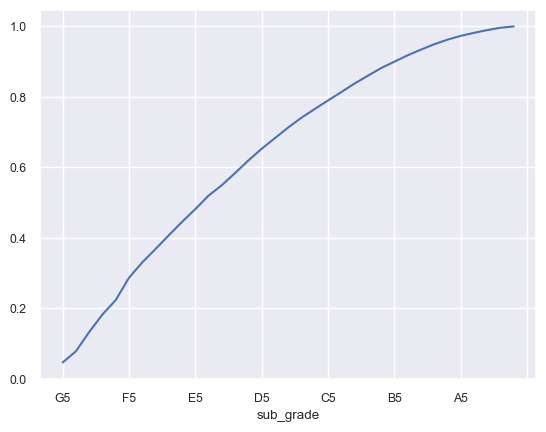

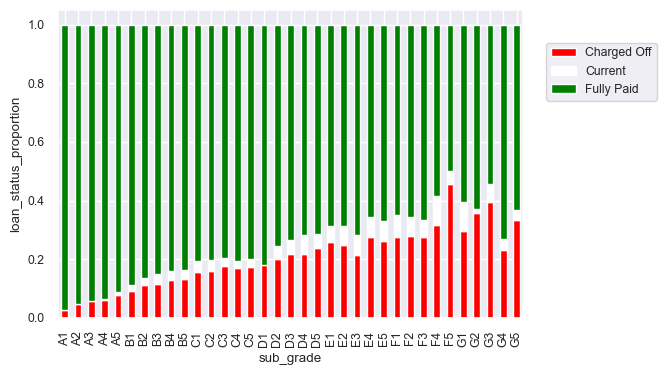

In [1522]:
CumSGrdVsLS = TblSGrdVersusLS.iloc[4,-2::-1]/TblSGrdVersusLS.loc["Prob_Def","All"]
CumSGrdVsLS.cumsum().plot.line()
TblSGrdVersusLS_perc = TblSGrdVersusLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
sb.set(font_scale=0.8)
TblSGrdVersusLS_perc.plot(kind="bar", stacked="True", figsize=[6,4],color=['red','white','green'])
plt.ylabel("loan_status_proportion")
plt.legend(bbox_to_anchor=(1.3, 0.8),loc='right')
plt.show()

#### Insights
- The grade and sub-grades seems to directly impact the tendency to default.
- Higher grade borrowers are less likely to default compared to lower grade borrowers (where grade 'A' is higher than 'B' is higher than 'C' and so on)
- Higher sub-grade borrowers are less likely to default compared to lower grade borrowers (where grade 'A1'>'A2'>'A3'...'B1'>'B2'.......'G4'>'G5' and so on)
- Some exceptions to above observations for sub-grade is seen between F4 to G5.
- The borrowers with sub-grades 'B4' to 'G5' have are 90% likely to default compared to borrowers between 'A1' to 'B3'.
- The median interest rates seem to  increase according to the borrowers grade.


***

#### Analysis of influence of purpose of loan with borrowers tendency to default
- Find the relationship between two catorical variables Grade and loan status
- Find the relationship between two catorical variables Sub-Grade and loan status
- Find the Prabability of Default(Charged Off) For each Grades/Sub-Grades

In [1523]:
LCLoanDf.purpose.value_counts(normalize=True)*100

debt_consolidation    46.934562
credit_card           12.916383
other                 10.053629
home_improvement       7.493013
major_purchase         5.506458
small_business         4.602563
car                    3.900093
wedding                2.384369
medical                1.744845
moving                 1.467885
vacation               0.959287
house                  0.959287
educational            0.818289
renewable_energy       0.259335
Name: purpose, dtype: float64

purpose           car  credit_card  debt_consolidation  educational  \
loan_status                                                           
Charged Off   160.000      542.000             2767.00       56.000   
Current        50.000      103.000              586.00          NaN   
Fully Paid   1339.000     4485.000            15288.00      269.000   
All          1549.000     5130.000            18641.00      325.000   
Prob_Def        0.007        0.007                0.01        0.012   

purpose      home_improvement    house  major_purchase  medical   moving  \
loan_status                                                                
Charged Off           347.000   59.000         222.000  106.000   92.000   
Current               101.000   14.000          37.000   12.000    7.000   
Fully Paid           2528.000  308.000        1928.000  575.000  484.000   
All                  2976.000  381.000        2187.000  693.000  583.000   
Prob_Def                0.008    0.011        

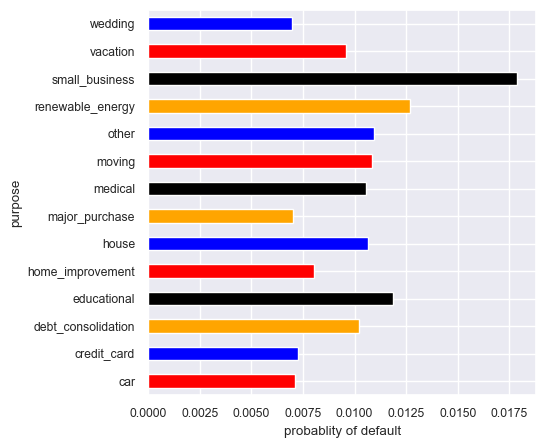

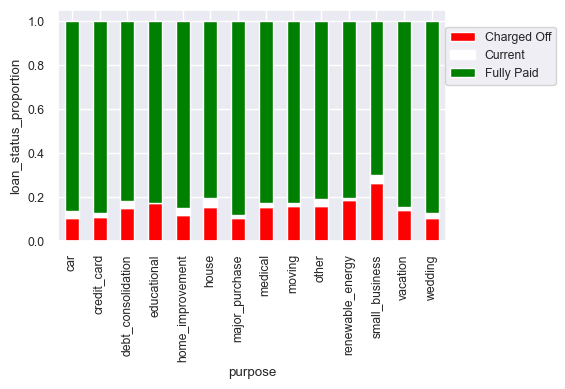

In [1524]:
## loan_status versus purpose
TblPurVersusLS = pd.crosstab(LCLoanDf.loan_status, LCLoanDf["purpose"], margins=True,     values=LCLoanDf["loan_status"], aggfunc='count').round(2)
TblPurVersusLS.loc["Prob_Def",:] = TblPurVersusLS.loc["Charged Off",:]/TblPurVersusLS.loc["All",:]
TblPurVersusLS.iloc[4,:-1] = TblPurVersusLS.iloc[4,:-1]/TblPurVersusLS.iloc[4,:-1].sum()*TblPurVersusLS.loc["Prob_Def","All"]
print(TblPurVersusLS.head().round(3))
c = ['red','blue','orange','black']
TblPurVersusLS.iloc[4,:-1].plot.barh(figsize=[5,5],color=c)
plt.show
plt.xlabel("probablity of default")
TblPurVersusLS_perc = TblPurVersusLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
TblPurVersusLS_perc.plot(kind="bar", stacked="True", figsize=[5,3],color=['red','white','green'])
plt.legend(bbox_to_anchor=(1.3, 0.8),loc='right')
plt.ylabel("loan_status_proportion")
plt.show()

***

#### Analysis of how the purpose of loan relates to the interest rates


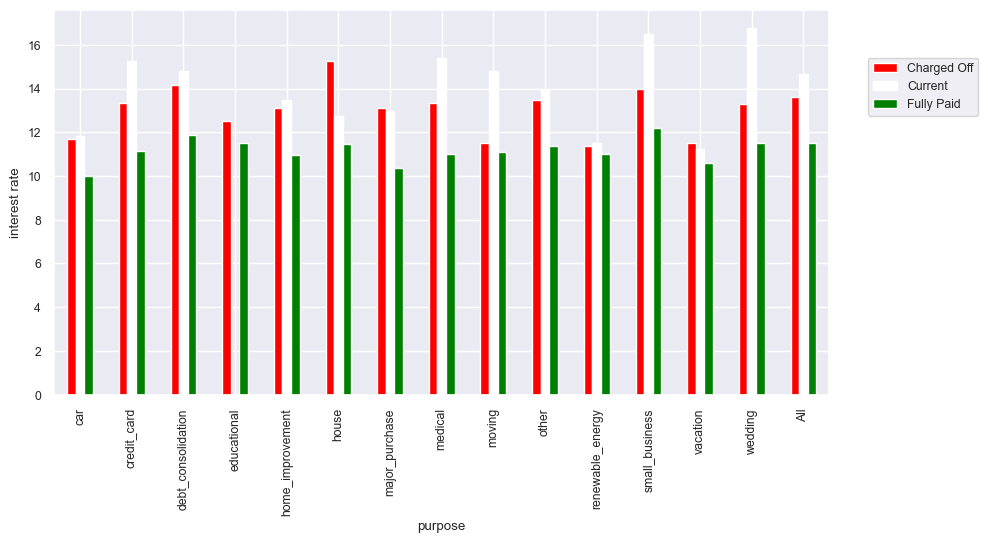

In [1525]:
LCLoanDf.int_rate.apply(lambda x:  x[:-1]).astype('float')
TblPurIntrate = pd.crosstab(LCLoanDf.int_rate.apply(lambda x:  x[:-1]).astype('float'), LCLoanDf["purpose"], margins=True,     values=LCLoanDf.int_rate.apply(lambda x:  x[:-1]).astype('float'), aggfunc='mean').round(2)
TblPurIntrate = pd.crosstab(LCLoanDf.loan_status, LCLoanDf["purpose"], margins=True,values=LCLoanDf.int_rate.apply(lambda x:  x[:-1]).astype('float'), aggfunc='median').round(2)
TblPurIntrate.iloc[:-1,:].transpose().plot.bar(figsize=[10,5],color=['red','white','green'])
plt.ylabel("interest rate")
plt.legend(bbox_to_anchor=(1.2, 0.8),loc='right')


### Insights
- loan taken for purposes of "small business" , "renewal_energy" , "education" seems to have higher default tendency compared to rest of the purposes.
- It is also seen that interest rates for "small business", "wedding" ,"medical","credit_card" etc have >14% median interest rates.

#### Recommendations
- Reduction of interest rates for "small business" may help in reducing the tendency to default. This may also increase the amount of applicants towards the "small business"
- Since the loan taken for "renewable_energy" purpose is lower and tendency of default is higher, the interest rates can be increased further to reduce the applicants for this purpose.



***

#### Spread of  annual Income of borrowers with loan borrowing purpose (Seen across loan_status)
- Find the relationship between two Numerical variable Annual income with catorical Loan Status and Purpose


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



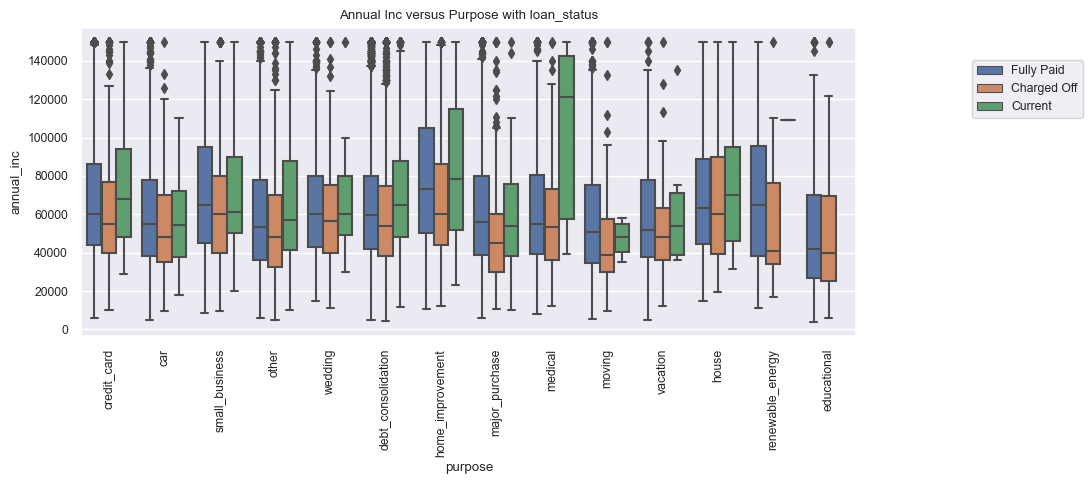

<function matplotlib.pyplot.show(close=None, block=None)>

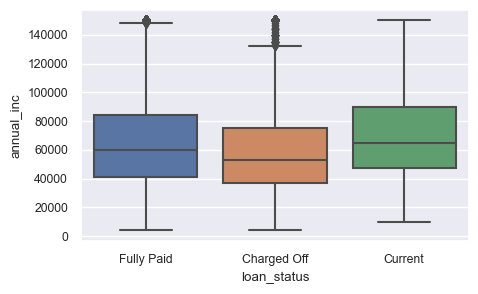

In [1526]:
plt.figure(figsize =(10, 4))
plt.title('Annual Inc versus Purpose with loan_status')
plt.xticks(rotation=90)
sb.set(font_scale=0.8)
ax=sb.boxplot('purpose','annual_inc',data=LCLoanDf,hue ='loan_status')
for patch in ax.artists:
 r, g, b, a = patch.get_facecolor()
 print(r)
 patch.set_facecolor((r, g, b, 1))
plt.legend(bbox_to_anchor=(1.3, 0.8),loc='right')
plt.show()
plt.figure(figsize =(5, 3))
sb.boxplot(x='loan_status', y='annual_inc', data=LCLoanDf)
plt.show 

### Insights
1. Loans taken with a with certain purpose categories like "home improvement","renewable_energy" seems to suggest that lower median annual income borrowers for these categories  are more likely to default than higher annual income borrowers.
2. The borrowers who defaulted have relatively lower income median compared to that the borrowers who fully paid the loan.

### Recommendations
- For certain purpose category of the loan it is recommended to review the annual income of the borrower to decide on the interest rates or reject the loan. Example for  "home improvement","renewable energy", "moving" or "major purchase" category there is a significant difference in the median annual income between defaulters and the fully paid borrowers.



#### Verification Status versus the Loan Status


verification_status,Not Verified,Source Verified,Verified,All
loan_status,,,,
Charged Off,2142.000,1434.000,2051.000,5627.000
Current,227.000,310.000,603.000,1140.000
Fully Paid,14552.000,8243.000,10155.000,32950.000
All,16921.000,9987.000,12809.000,39717.000
Prob_Def,0.042,0.047,0.053,0.142


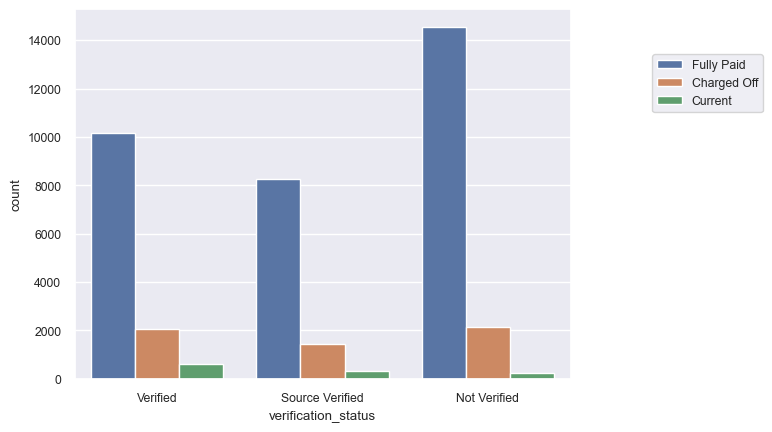

In [1527]:
#LCLoanDf.loc[5].value_counts().size
sb.set(font_scale=0.8)
sb.countplot(data=LCLoanDf,x='verification_status',hue='loan_status')
plt.legend(bbox_to_anchor=(1.4, 0.8),loc='right')

## 
#LC1b_VervsLS = LCLoanDf.filter(items =["verification_status","loan_status"] )
TblVervsLS = pd.crosstab(LCLoanDf.loan_status, LCLoanDf["verification_status"], margins=True,values=LCLoanDf["loan_status"], aggfunc='count').round(2)
TblVervsLS.loc["Prob_Def",:] = TblVervsLS.loc["Charged Off",:]/TblVervsLS.loc["All",:]
TblVervsLS.iloc[4,:-1] = TblVervsLS.iloc[4,:-1]/TblVervsLS.iloc[4,:-1].sum()*TblVervsLS.loc["Prob_Def","All"]
TblVervsLS.round(3)

### Insights
- Verified borrower still has slightly higher likehood of defaulting than the source verified or non verified borrower

***

### Analysis of employment length on the tendency of default.


In [1528]:
#LC1b_ELvsLS = LCLoanDf.filter(items =["emp_length","loan_status"] )
Tbl_ELvsLS = pd.crosstab(LCLoanDf.loan_status, LCLoanDf["emp_length"], margins=True,     values=LCLoanDf["loan_status"], aggfunc='count').round(2)
Tbl_ELvsLS.loc["Prob_Def",:] = Tbl_ELvsLS.loc["Charged Off",:]/Tbl_ELvsLS.loc["All",:]
Tbl_ELvsLS.iloc[4,:-1] = Tbl_ELvsLS.iloc[4,:-1]/Tbl_ELvsLS.iloc[4,:-1].sum()*Tbl_ELvsLS.loc["Prob_Def","All"]
Tbl_ELvsLS = Tbl_ELvsLS.fillna(0).round(3)
Tbl_ELvsLS.head()

emp_length,0,1,2,3,4,5,6,7,8,9,10,All
loan_status,,,,,,,,,,,,
Charged Off,867.000,456.000,567.000,555.000,462.000,458.000,307.000,263.000,203.000,158.000,1331.000,5627.000
Current,117.000,71.000,97.000,83.000,94.000,88.000,61.000,62.000,44.000,32.000,391.000,1140.000
Fully Paid,4674.000,2713.000,3724.000,3457.000,2880.000,2736.000,1861.000,1448.000,1232.000,1068.000,7157.000,32950.000
All,5658.000,3240.000,4388.000,4095.000,3436.000,3282.000,2229.000,1773.000,1479.000,1258.000,8879.000,39717.000
Prob_Def,0.014,0.013,0.012,0.013,0.012,0.013,0.013,0.014,0.013,0.012,0.014,0.142


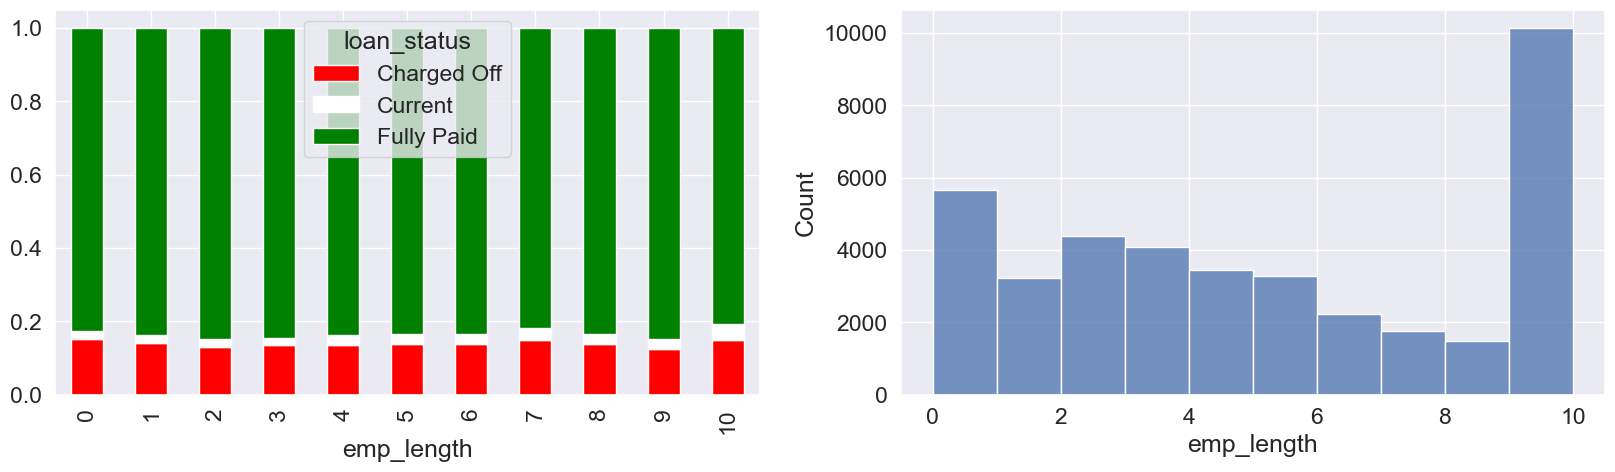

In [1529]:
sb.set(font_scale=1.5)
Tbl_ELvsLS_perc = Tbl_ELvsLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_ELvsLS_perc.plot(kind="bar", stacked="True",ax=axes[0],color=['red','white','green'])
sb.histplot(LCLoanDf.emp_length,bins=10,ax=axes[1])
plt.show()

#### Insights
1. The tendency to default doesnt seem to show a strong dependency on the length of employment.



####  Influence of Home ownership status with the loan status

In [1530]:
Tbl_HOVsLS= pd.crosstab(LCLoanDf.loan_status, LCLoanDf["home_ownership"], margins=True,     values=LCLoanDf["loan_status"], aggfunc='count').round(2)
Tbl_HOVsLS.loc["Prob_Def",:] = Tbl_HOVsLS.loc["Charged Off",:]/Tbl_HOVsLS.loc["All",:]
Tbl_HOVsLS.iloc[4,:-1] = Tbl_HOVsLS.iloc[4,:-1]/Tbl_HOVsLS.iloc[4,:-1].sum()*Tbl_HOVsLS.loc["Prob_Def","All"]

Tbl_HOVsLS = Tbl_HOVsLS.fillna(0).round(2)
Tbl_HOVsLS

home_ownership,MORTGAGE,NONE,OTHER,OWN,RENT,All
loan_status,,,,,,
Charged Off,2327.00,0.0,18.00,443.00,2839.00,5627.00
Current,638.00,0.0,0.00,83.00,419.00,1140.00
Fully Paid,14694.00,3.0,80.00,2532.00,15641.00,32950.00
All,17659.00,3.0,98.00,3058.00,18899.00,39717.00
Prob_Def,0.03,0.0,0.04,0.03,0.03,0.14


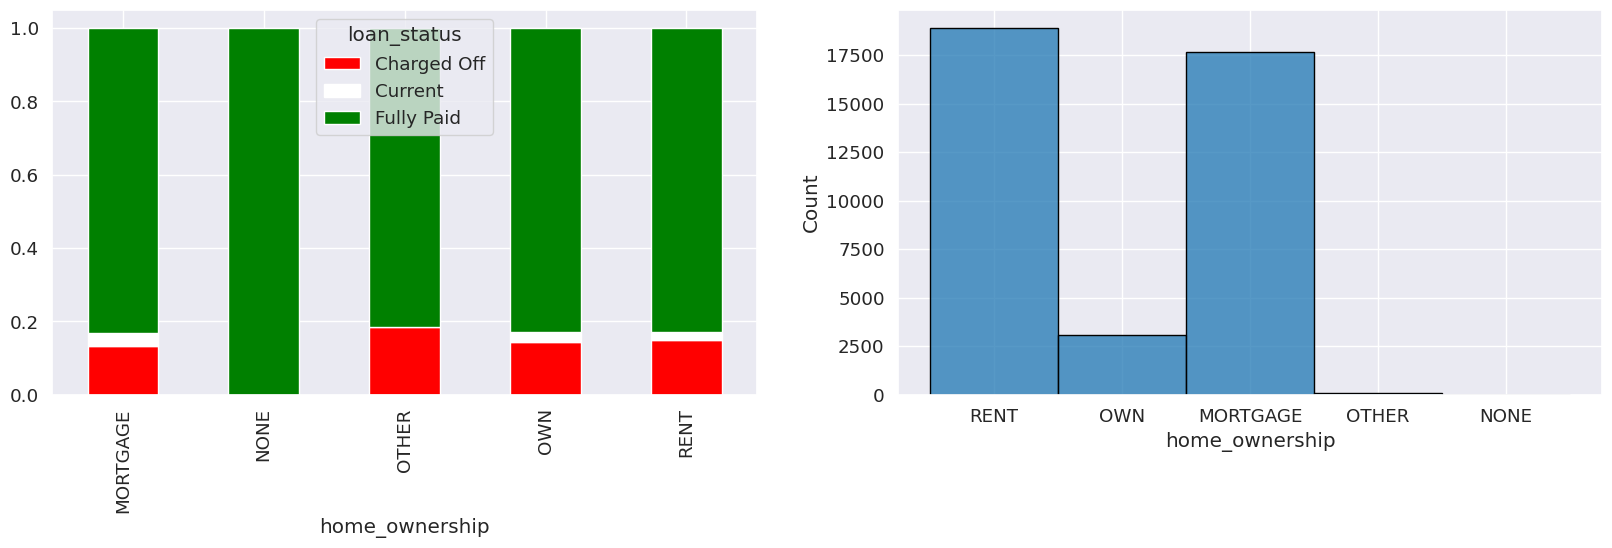

In [1531]:
sb.set(font_scale=1.2)
Tbl_HOVsLS_perc = Tbl_HOVsLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_HOVsLS_perc.plot(ax=axes[0],kind="bar", stacked="True",color=['red','white','green'])
sb.reset_defaults()
sb.histplot(LCLoanDf.home_ownership,ax=axes[1],bins=20)
plt.show()

#### Insights
1. The tendency to default doesnt seem to show a strong dependency on the Home ownership status.


***

####  Influence of percentate of funding from investor to loan status

funded_loan_perc_cat     <75%  >75<80%  >80<85  >85<90   >90<95   >95<100  \
loan_status                                                                 
Charged Off            614.00    56.00   76.00  119.00   218.00   4496.00   
Current                 63.00    15.00    6.00   14.00    38.00   1004.00   
Fully Paid            2712.00   285.00  302.00  614.00  1387.00  27542.00   
All                   3389.00   356.00  384.00  747.00  1643.00  33042.00   
Prob_Def                 0.03     0.02    0.03    0.02     0.02      0.02   

funded_loan_perc_cat       All  
loan_status                     
Charged Off            5579.00  
Current                1140.00  
Fully Paid            32842.00  
All                   39561.00  
Prob_Def                  0.14  


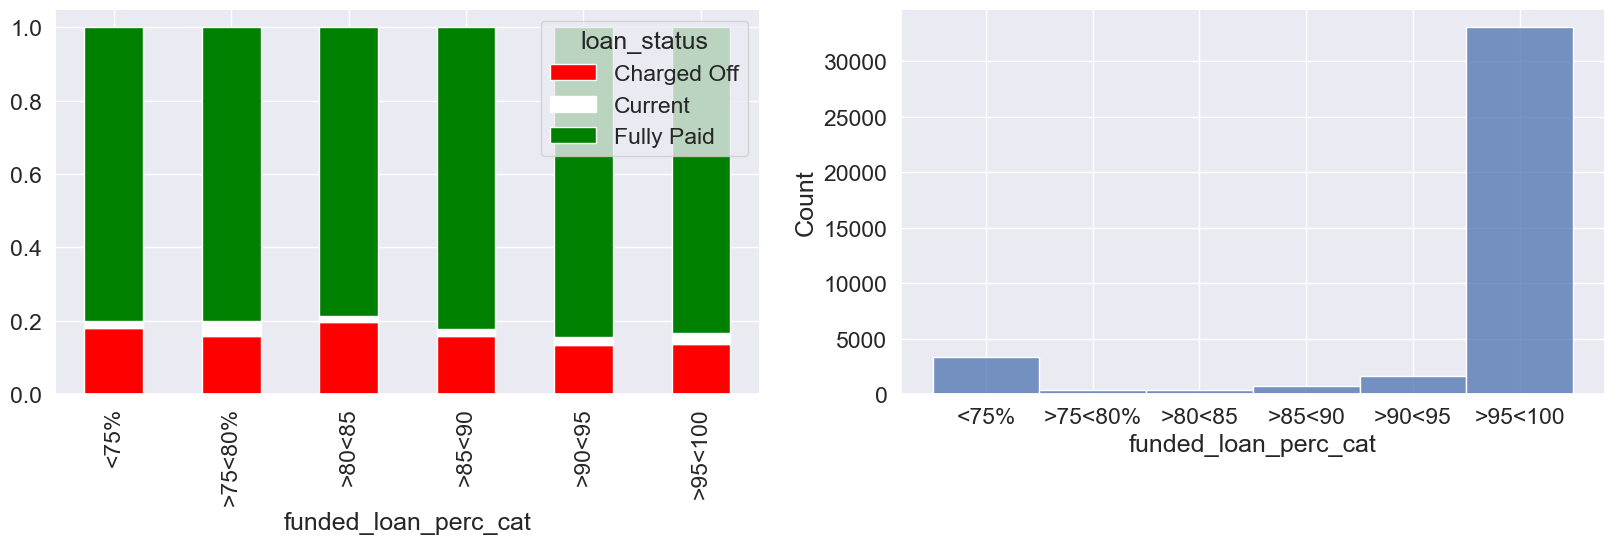

In [1532]:
LCLoanDf_ooc["funded_loan_perc_cat"]=pd.cut(LCLoanDf.funded_loan_perc,bins=[0,75,80,85,90,95,100],labels=['<75%','>75<80%','>80<85','>85<90','>90<95','>95<100'])
#LCLoanDf_ooc["total_acc_cat"].value_counts()

Tbl_DelvsLS = pd.crosstab(LCLoanDf_ooc.loan_status, LCLoanDf_ooc["funded_loan_perc_cat"], margins=True,     values=LCLoanDf_ooc["loan_status"], aggfunc='count').round(2)
Tbl_DelvsLS.loc["Prob_Def",:] = Tbl_DelvsLS.loc["Charged Off",:]/Tbl_DelvsLS.loc["All",:]
Tbl_DelvsLS.iloc[4,:-1] = Tbl_DelvsLS.iloc[4,:-1]/Tbl_DelvsLS.iloc[4,:-1].sum()*Tbl_DelvsLS.loc["Prob_Def","All"]
Tbl_DelvsLS.loc["Prob_Def",:]  = Tbl_DelvsLS.loc["Prob_Def",:].round(2)
Tbl_DelvsLS = Tbl_DelvsLS.fillna(0)
print(Tbl_DelvsLS.head().round(2))
sb.set(font_scale=1.5)
Tbl_DelvsLS_perc = Tbl_DelvsLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_DelvsLS_perc.plot(ax=axes[0],kind="bar", stacked="True",color=['red','white','green'])
sb.histplot(LCLoanDf_ooc.funded_loan_perc_cat,ax=axes[1],bins=20)
plt.show()

## Out of Curiosity(Additional analysis)
### Influence of borrowers general behavioural attributes
- Some general borrowers behavioural variables are considered in this additional analysis.
- A FICO or a Vantage score which is probhably a function of probably the variables like "delinq_2yrs","inq_last_6mths","total_acc","pub_rec","mths_since_last_delinq","mths_since_last_delinq" ..etc will be typically available for a general borrower based on his credit history with other lending channels. 
- In this section we consider each of these behavioural variables and see whether there is any impact  borrowers tendency to default.

In [1533]:
LCLoanDf_ooc.info()
loanC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   id                      39717 non-null  int64   
 1   member_id               39717 non-null  int64   
 2   loan_amnt               39717 non-null  int64   
 3   funded_amnt             39717 non-null  int64   
 4   funded_amnt_inv         39717 non-null  float64 
 5   term                    39717 non-null  object  
 6   int_rate                39717 non-null  object  
 7   installment             39717 non-null  float64 
 8   grade                   39717 non-null  object  
 9   sub_grade               39717 non-null  object  
 10  emp_length              38642 non-null  object  
 11  home_ownership          39717 non-null  object  
 12  annual_inc              39717 non-null  float64 
 13  verification_status     39717 non-null  object  
 14  issue_d               

#### Analysis of how deliquency in 2years span impacts the loan_status and tendency to default

delinq_2yrs         0        1       2       3      4      5      6     7  \
loan_status                                                                 
Charged Off   4936.00   507.00  130.00   35.00  13.00   3.00   1.00  1.00   
Current       1019.00    96.00   14.00    8.00   2.00   1.00   0.00  0.00   
Fully Paid   29450.00  2700.00  543.00  177.00  47.00  18.00   9.00  3.00   
All          35405.00  3303.00  687.00  220.00  62.00  22.00  10.00  4.00   
Prob_Def         0.01     0.01    0.01    0.01   0.02   0.01   0.01  0.02   

delinq_2yrs     8    9   11       All  
loan_status                            
Charged Off  1.00  0.0  0.0   5627.00  
Current      0.00  0.0  0.0   1140.00  
Fully Paid   1.00  1.0  1.0  32950.00  
All          2.00  1.0  1.0  39717.00  
Prob_Def     0.04  0.0  0.0      0.14  


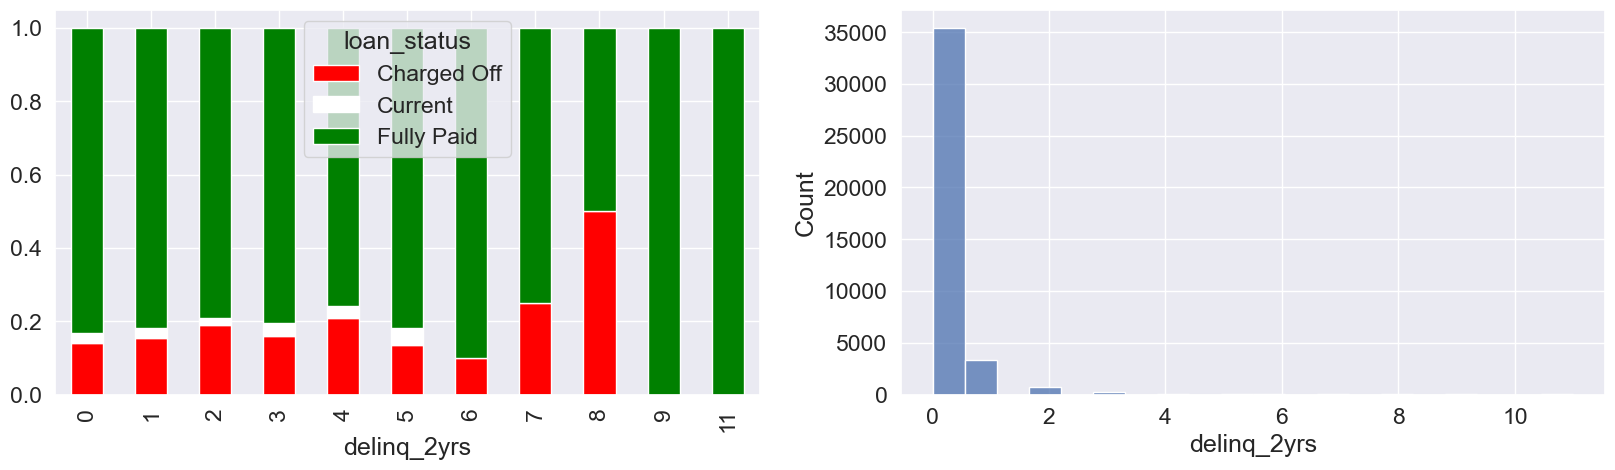

In [1534]:
Tbl_Gen = pd.crosstab(LCLoanDf_ooc.loan_status, LCLoanDf_ooc["delinq_2yrs"], margins=True,     values=LCLoanDf_ooc["loan_status"], aggfunc='count').round(2)
Tbl_Gen.loc["Prob_Def",:] = Tbl_Gen.loc["Charged Off",:]/Tbl_Gen.loc["All",:]
Tbl_Gen.iloc[4,:-1] = Tbl_Gen.iloc[4,:-1]/Tbl_Gen.iloc[4,:-1].sum()*Tbl_Gen.loc["Prob_Def","All"]
Tbl_Gen.loc["Prob_Def",:]  = Tbl_Gen.loc["Prob_Def",:].round(2)
Tbl_Gen = Tbl_Gen.fillna(0)
print(Tbl_Gen.head().round(2))
sb.set(font_scale=1.5)
Tbl_Gen_perc = Tbl_Gen.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_Gen_perc.plot(ax=axes[0],kind="bar", stacked="True",color=['red','white','green'])
sb.histplot(LCLoanDf_ooc.delinq_2yrs,ax=axes[1],bins=20)
plt.show()

pub_rec             0        1      2    3    4       All
loan_status                                              
Charged Off   5160.00   457.00  10.00  0.0  0.0   5627.00
Current       1094.00    43.00   3.00  0.0  0.0   1140.00
Fully Paid   31347.00  1556.00  38.00  7.0  2.0  32950.00
All          37601.00  2056.00  51.00  7.0  2.0  39717.00
Prob_Def         0.03     0.06   0.05  0.0  0.0      0.14


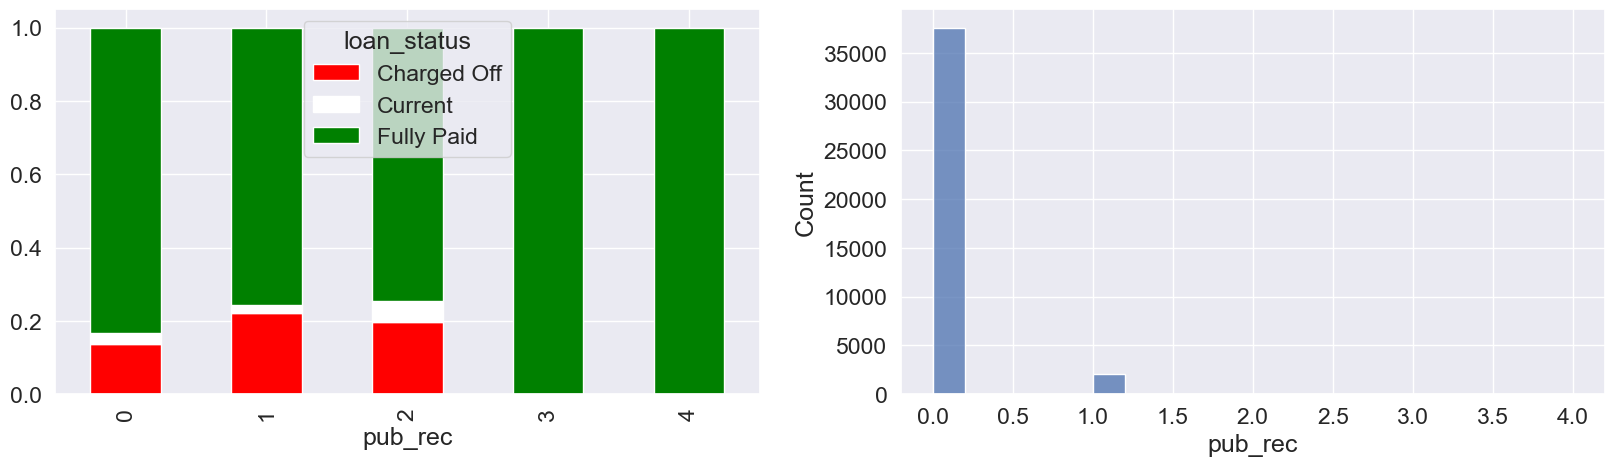

In [1535]:
Tbl_Gen = pd.crosstab(LCLoanDf_ooc.loan_status, LCLoanDf_ooc["pub_rec"], margins=True,     values=LCLoanDf_ooc["loan_status"], aggfunc='count').round(2)
Tbl_Gen.loc["Prob_Def",:] = Tbl_Gen.loc["Charged Off",:]/Tbl_Gen.loc["All",:]
Tbl_Gen.iloc[4,:-1] = Tbl_Gen.iloc[4,:-1]/Tbl_Gen.iloc[4,:-1].sum()*Tbl_Gen.loc["Prob_Def","All"]
Tbl_Gen.loc["Prob_Def",:]  = Tbl_Gen.loc["Prob_Def",:].round(2)
Tbl_Gen = Tbl_Gen.fillna(0)
print(Tbl_Gen.head().round(2))
sb.set(font_scale=1.5)
Tbl_Gen_perc = Tbl_Gen.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_Gen_perc.plot(ax=axes[0],kind="bar", stacked="True",color=['red','white','green'])
sb.histplot(LCLoanDf_ooc.pub_rec,ax=axes[1],bins=20)
plt.show()

#### Insights
- For pub_rec (# of derogatory public records) the sample size for higher value is less and hence it is difficult to conclude on its dependency on the tendency of default.
- For deliq_2yrs(# of 30+ days past due incidents of deliquencies) the sample size for '6' is lower and it may not be possible to conclude on the borrowers tendency to default.However for significant sample size it is seen that there is a slight trend in the likelyhood  of default for this parameter.




#### Analysis of how the number of inquiries in past 6 months impacts the borrowers tendency to default

inq_last_6mths         0         1        2        3       4       5      6  \
loan_status                                                                   
Charged Off      2280.00   1677.00   943.00   619.00   51.00   28.00  16.00   
Current           591.00    311.00   158.00    65.00   10.00    2.00   1.00   
Fully Paid      16429.00   8983.00  4711.00  2364.00  265.00  116.00  47.00   
All             19300.00  10971.00  5812.00  3048.00  326.00  146.00  64.00   
Prob_Def            0.01      0.01     0.01     0.02    0.01    0.02   0.02   

inq_last_6mths      7      8       All  
loan_status                             
Charged Off     10.00   3.00   5627.00  
Current          1.00   1.00   1140.00  
Fully Paid      24.00  11.00  32950.00  
All             35.00  15.00  39717.00  
Prob_Def         0.02   0.02      0.14  


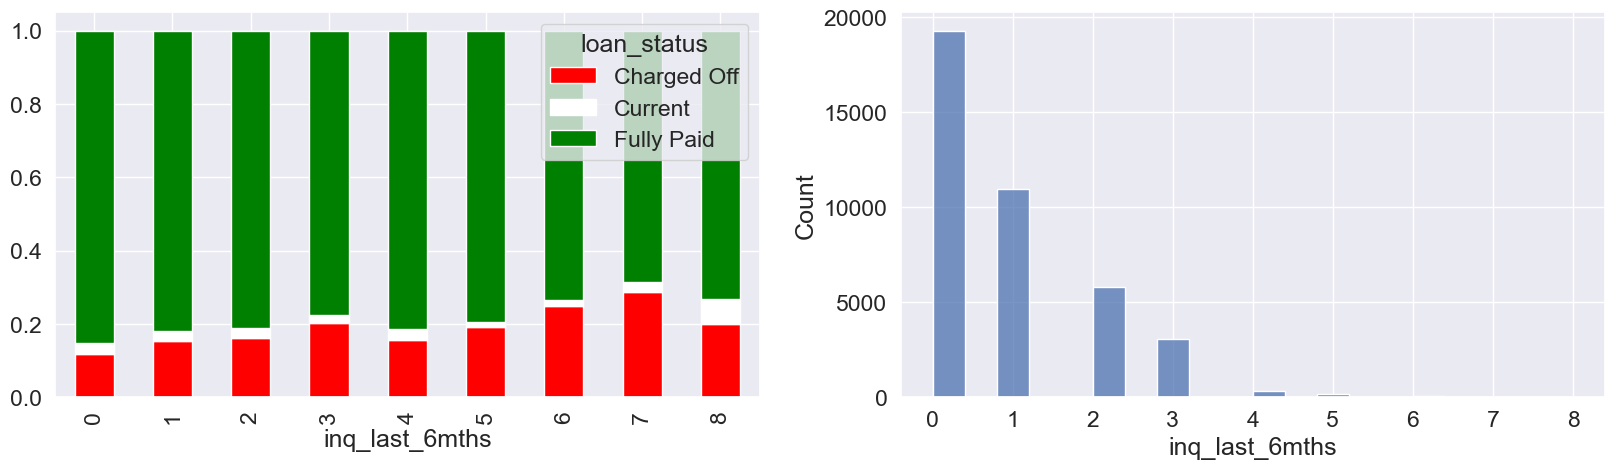

In [1536]:
Tbl_Gen = pd.crosstab(LCLoanDf_ooc.loan_status, LCLoanDf_ooc["inq_last_6mths"], margins=True,     values=LCLoanDf_ooc["loan_status"], aggfunc='count').round(2)
Tbl_Gen.loc["Prob_Def",:] = Tbl_Gen.loc["Charged Off",:]/Tbl_Gen.loc["All",:]
Tbl_Gen.iloc[4,:-1] = Tbl_Gen.iloc[4,:-1]/Tbl_Gen.iloc[4,:-1].sum()*Tbl_Gen.loc["Prob_Def","All"]
Tbl_Gen.loc["Prob_Def",:]  = Tbl_Gen.loc["Prob_Def",:].round(2)
Tbl_Gen = Tbl_Gen.fillna(0)
print(Tbl_Gen.head().round(2))
sb.set(font_scale=1.5)
Tbl_Gen_perc = Tbl_Gen.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_Gen_perc.plot(ax=axes[0],kind="bar", stacked="True",color=['red','white','green'])
sb.histplot(LCLoanDf_ooc.inq_last_6mths,ax=axes[1],bins=20)
plt.show()

#### Insights
- For inq_last_6months(The number of inquiries in past 6 months (excluding auto and mortgage inquiries) the higher number of queries are having higher borrower tendency to default. The samplesize for higher # of enquires may not be sufficient to conclude on the tendency to default.


#### Analysis of how the number of open credit lines in Borrower's credit file influences the borrowers tendency to default 

open_acc_cat       <10    >10<20  >20<30  >30<40  >40<50       All
loan_status                                                       
Charged Off    3803.00   1707.00  109.00    8.00     0.0   5627.00
Current         715.00    396.00   28.00    1.00     0.0   1140.00
Fully Paid    21947.00  10390.00  592.00   18.00     3.0  32950.00
All           26465.00  12493.00  729.00   27.00     3.0  39717.00
Prob_Def          0.03      0.03    0.03    0.06     0.0      0.14


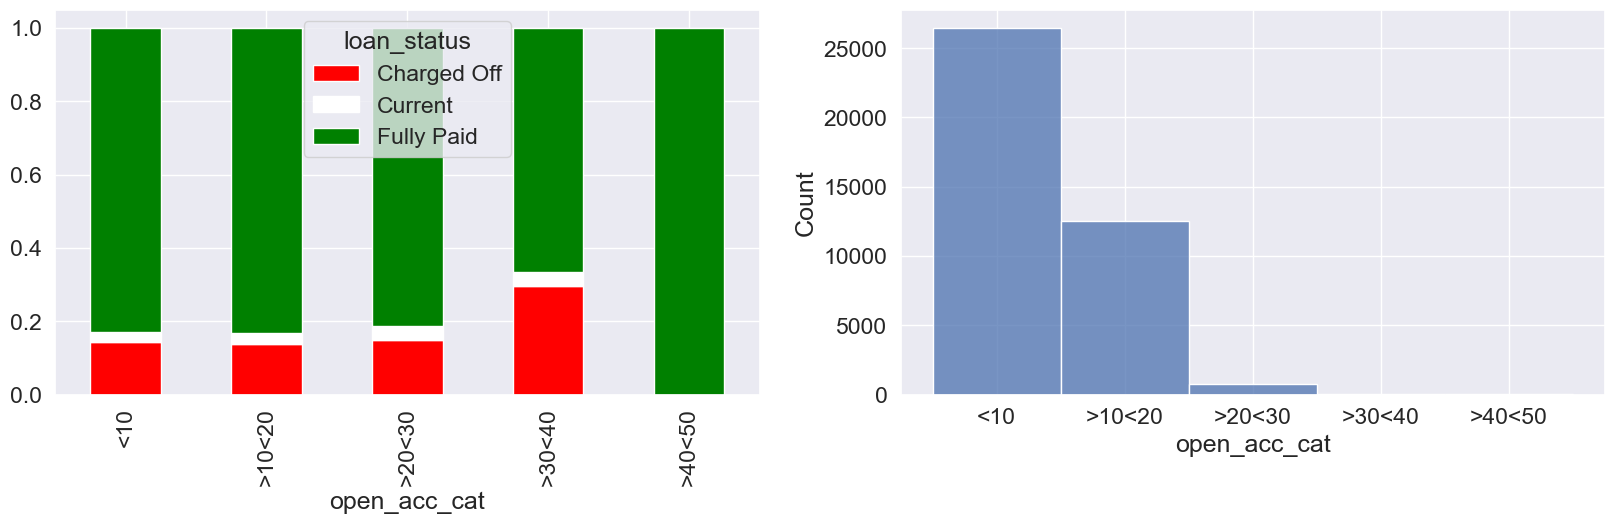

In [1537]:
LCLoanDf_ooc["open_acc_cat"]=pd.cut(LCLoanDf_ooc.open_acc,bins=[0,10,20,30,40,50],labels=['<10','>10<20','>20<30','>30<40','>40<50'])
LCLoanDf_ooc["open_acc_cat"].value_counts()

Tbl_Gen = pd.crosstab(LCLoanDf_ooc.loan_status, LCLoanDf_ooc["open_acc_cat"], margins=True,     values=LCLoanDf_ooc["loan_status"], aggfunc='count').round(2)
Tbl_Gen.loc["Prob_Def",:] = Tbl_Gen.loc["Charged Off",:]/Tbl_Gen.loc["All",:]
Tbl_Gen.iloc[4,:-1] = Tbl_Gen.iloc[4,:-1]/Tbl_Gen.iloc[4,:-1].sum()*Tbl_Gen.loc["Prob_Def","All"]
Tbl_Gen.loc["Prob_Def",:]  = Tbl_Gen.loc["Prob_Def",:].round(2)
Tbl_Gen = Tbl_Gen.fillna(0)
print(Tbl_Gen.head().round(2))
sb.set(font_scale=1.5)
Tbl_Gen_perc = Tbl_Gen.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_Gen_perc.plot(ax=axes[0],kind="bar", stacked="True",color=['red','white','green'])
sb.histplot(LCLoanDf_ooc.open_acc_cat,ax=axes[1],bins=20)
plt.show()

#### Insights
- Borrowers with the open credit lines between 30-40 seems to be showing higher tendency to default.


#### Analysis of how the the total number of credit lines currently in the borrower's credit file influences tendency to default

total_acc_cat       <20    >20<40   >40<60  >60<80  >80<100       All
loan_status                                                          
Charged Off     2993.00   2259.00   349.00   26.00      0.0   5627.00
Current          491.00    577.00    68.00    4.00      0.0   1140.00
Fully Paid     16478.00  14132.00  2160.00  177.00      3.0  32950.00
All            19962.00  16968.00  2577.00  207.00      3.0  39717.00
Prob_Def           0.04      0.03     0.04    0.03      0.0      0.14


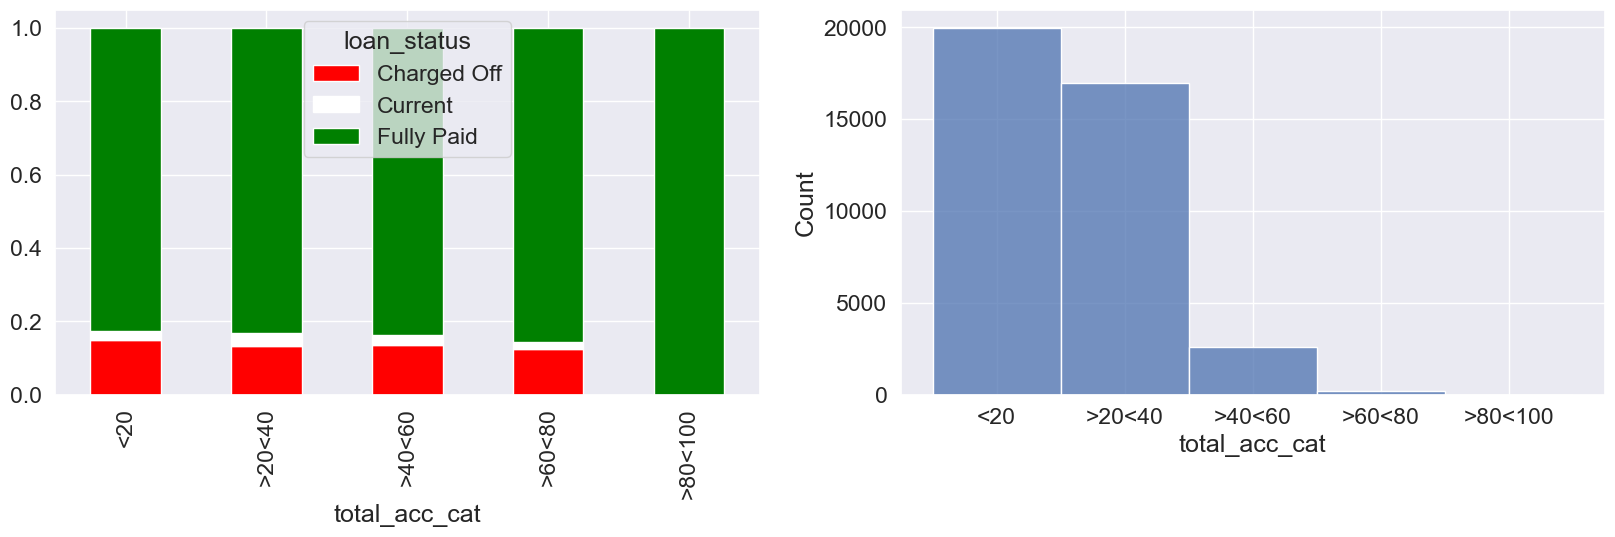

In [1538]:
LCLoanDf_ooc["total_acc_cat"]=pd.cut(LCLoanDf_ooc.total_acc,bins=[0,20,40,60,80,100],labels=['<20','>20<40','>40<60','>60<80','>80<100'])
LCLoanDf_ooc["total_acc_cat"].value_counts()

Tbl_Gen = pd.crosstab(LCLoanDf_ooc.loan_status, LCLoanDf_ooc["total_acc_cat"], margins=True,     values=LCLoanDf_ooc["loan_status"], aggfunc='count').round(2)
Tbl_Gen.loc["Prob_Def",:] = Tbl_Gen.loc["Charged Off",:]/Tbl_Gen.loc["All",:]
Tbl_Gen.iloc[4,:-1] = Tbl_Gen.iloc[4,:-1]/Tbl_Gen.iloc[4,:-1].sum()*Tbl_Gen.loc["Prob_Def","All"]
Tbl_Gen.loc["Prob_Def",:]  = Tbl_Gen.loc["Prob_Def",:].round(2)
Tbl_Gen = Tbl_Gen.fillna(0)
print(Tbl_Gen.head().round(2))
sb.set(font_scale=1.5)
Tbl_Gen_perc = Tbl_Gen.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_Gen_perc.plot(ax=axes[0],kind="bar", stacked="True",color=['red','white','green'])
sb.histplot(LCLoanDf_ooc.total_acc_cat,ax=axes[1],bins=20)
plt.show()

#### Insights
-There is no impact of total_acc on the borrowers tendency to default

#### Analysis of how the revolving credit balance and revolving credit utilization% of the borrower impact the tendency to default
- Revolving utilization rate compares your credit debt to your total credit limit. To calculate it, divide your balance by your credit limit. Let’s say you have a dollar 2,000 balance on a credit card with a dollar 5,000 limit. Your utilization rate would be 40%.
- X opens a credit card with a dollar 1,000 credit limit and an interest rate of 14.99. She makes a purchase of dollar 200. X understands he will pay interest on the balance until he pays it off, but he decides to carry a revolving balance. If X pays only the minimum payment of dollar 20 per month, it will take her 11 months to pay off her balance. This is an example of a revolving balance

In [1566]:
LCLoanDf_ooc["revol_util"].fillna('0%').astype('str').apply(lambda x:  x[:-1]).astype("float").describe()

count    39717.000000
mean        48.770677
std         28.367689
min          0.000000
25%         25.300000
50%         49.200000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64

revol_util_cat     <20%  >20%<40%  >40%<60%  >60%<80%     >80%       All
loan_status                                                             
Charged Off      626.00    915.00   1236.00   1356.00  1334.00   5467.00
Current          133.00    220.00    257.00    286.00   221.00   1117.00
Fully Paid      6180.00   6790.00   7172.00   6658.00  5306.00  32106.00
All             6939.00   7925.00   8665.00   8300.00  6861.00  38690.00
Prob_Def           0.02      0.02      0.03      0.03     0.04      0.14


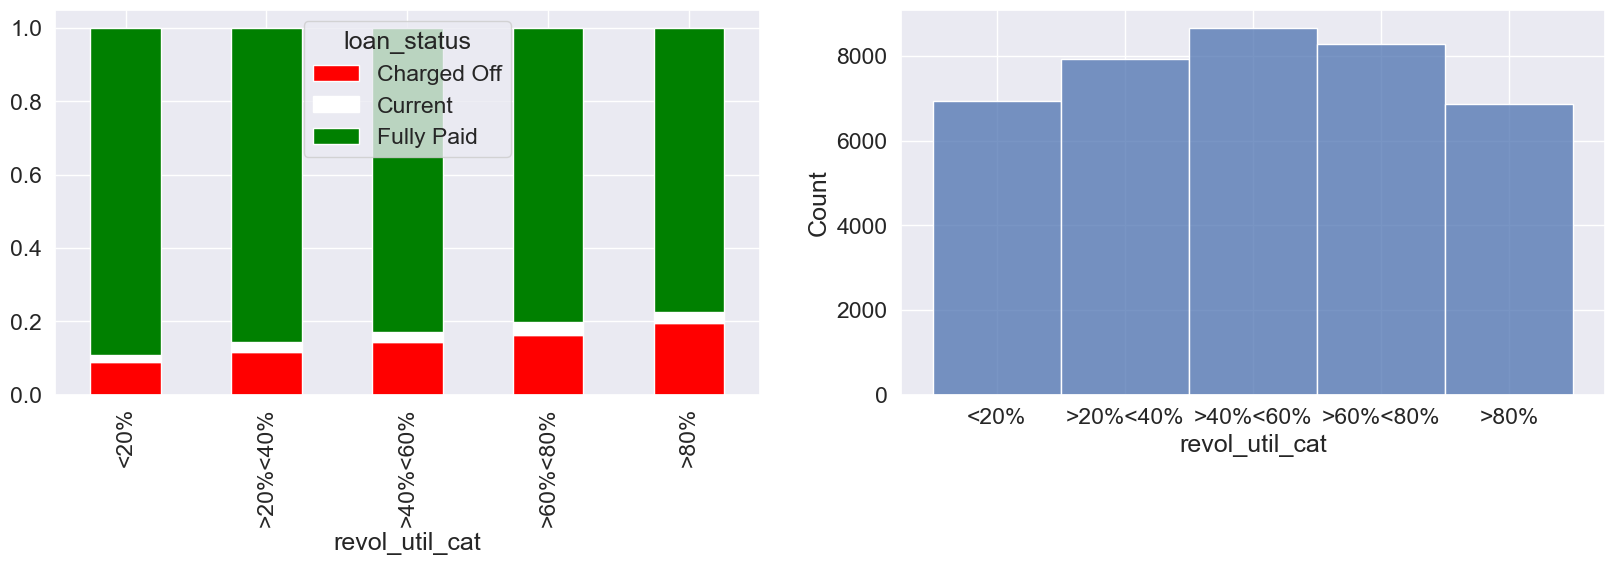

In [1569]:
LCLoanDf_ooc["revol_util_cat"]=pd.cut(LCLoanDf_ooc["revol_util"].fillna('0%').astype('str').apply(lambda x:  x[:-1]).astype("float"),bins=[0,20,40,60,80,100],labels=['<20%','>20%<40%','>40%<60%','>60%<80%','>80%'])
Tbl_Gen = pd.crosstab(LCLoanDf_ooc.loan_status, LCLoanDf_ooc["revol_util_cat"], margins=True,     values=LCLoanDf_ooc["loan_status"], aggfunc='count').round(2)
Tbl_Gen.loc["Prob_Def",:] = Tbl_Gen.loc["Charged Off",:]/Tbl_Gen.loc["All",:]
Tbl_Gen.iloc[4,:-1] = Tbl_Gen.iloc[4,:-1]/Tbl_Gen.iloc[4,:-1].sum()*Tbl_Gen.loc["Prob_Def","All"]
Tbl_Gen.loc["Prob_Def",:]  = Tbl_Gen.loc["Prob_Def",:].round(2)
Tbl_Gen = Tbl_Gen.fillna(0)
print(Tbl_Gen.head().round(2))
sb.set(font_scale=1.5)
Tbl_Gen_perc = Tbl_Gen.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_Gen_perc.plot(ax=axes[0],kind="bar", stacked="True",color=['red','white','green'])
sb.histplot(LCLoanDf_ooc.revol_util_cat,ax=axes[1],bins=20)
plt.show()

revol_bal_cat       <5K  >5K<10K  >10K<20K  >20K<30K  >30K<40K  >40K<50K  \
loan_status                                                                
Charged Off     1536.00  1295.00   1480.00    607.00    237.00    152.00   
Current          216.00   223.00    355.00    179.00     60.00     39.00   
Fully Paid      9932.00  7476.00   8409.00   3245.00   1331.00    601.00   
All            11684.00  8994.00  10244.00   4031.00   1628.00    792.00   
Prob_Def           0.02     0.02      0.02      0.02      0.02      0.03   

revol_bal_cat     >50K       All  
loan_status                       
Charged Off     162.00   5469.00  
Current          46.00   1118.00  
Fully Paid     1142.00  32136.00  
All            1350.00  38723.00  
Prob_Def          0.02      0.14  


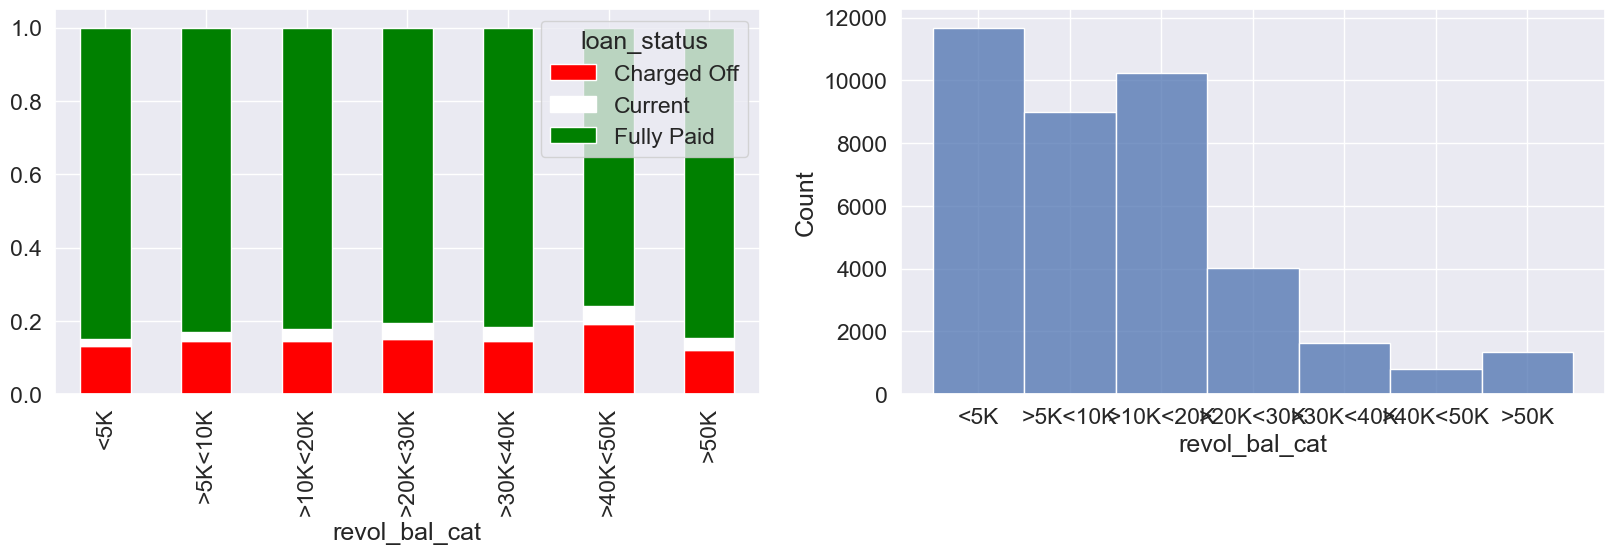

In [1571]:
LCLoanDf_ooc["revol_bal_cat"]=pd.cut(LCLoanDf_ooc.revol_bal,bins=[0,5000,10000,20000,30000,40000,50000,150000],labels=['<5K','>5K<10K','>10K<20K','>20K<30K','>30K<40K','>40K<50K','>50K'])
#LCLoanDf_ooc["total_acc_cat"].value_counts()

Tbl_Gen = pd.crosstab(LCLoanDf_ooc.loan_status, LCLoanDf_ooc["revol_bal_cat"], margins=True,     values=LCLoanDf_ooc["loan_status"], aggfunc='count').round(2)
Tbl_Gen.loc["Prob_Def",:] = Tbl_Gen.loc["Charged Off",:]/Tbl_Gen.loc["All",:]
Tbl_Gen.iloc[4,:-1] = Tbl_Gen.iloc[4,:-1]/Tbl_Gen.iloc[4,:-1].sum()*Tbl_Gen.loc["Prob_Def","All"]
Tbl_Gen.loc["Prob_Def",:]  = Tbl_Gen.loc["Prob_Def",:].round(2)
Tbl_Gen = Tbl_Gen.fillna(0)
print(Tbl_Gen.head().round(2))
sb.set(font_scale=1.5)
Tbl_Gen_perc = Tbl_Gen.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_Gen_perc.plot(ax=axes[0],kind="bar", stacked="True",color=['red','white','green'])
sb.histplot(LCLoanDf_ooc.revol_bal_cat,ax=axes[1],bins=20)
plt.show()

### Insights
- The revolving credit utilization % seems to have a weak influence on borrowers tendency to default.
- Higher percentage of revolving credit utilization higher the borrowers tendency to default.

***

mths_since_last_delinq_cat      <20   >20<40   >40<60   >60<80     >80  \
loan_status                                                              
Charged Off                  580.00   606.00   500.00   356.00   33.00   
Current                      106.00   112.00    78.00    65.00    2.00   
Fully Paid                  2932.00  3672.00  2637.00  1785.00  128.00   
All                         3618.00  4390.00  3215.00  2206.00  163.00   
Prob_Def                       0.03     0.03     0.03     0.03    0.04   

mths_since_last_delinq_cat       All  
loan_status                           
Charged Off                  2075.00  
Current                       363.00  
Fully Paid                  11154.00  
All                         13592.00  
Prob_Def                        0.15  


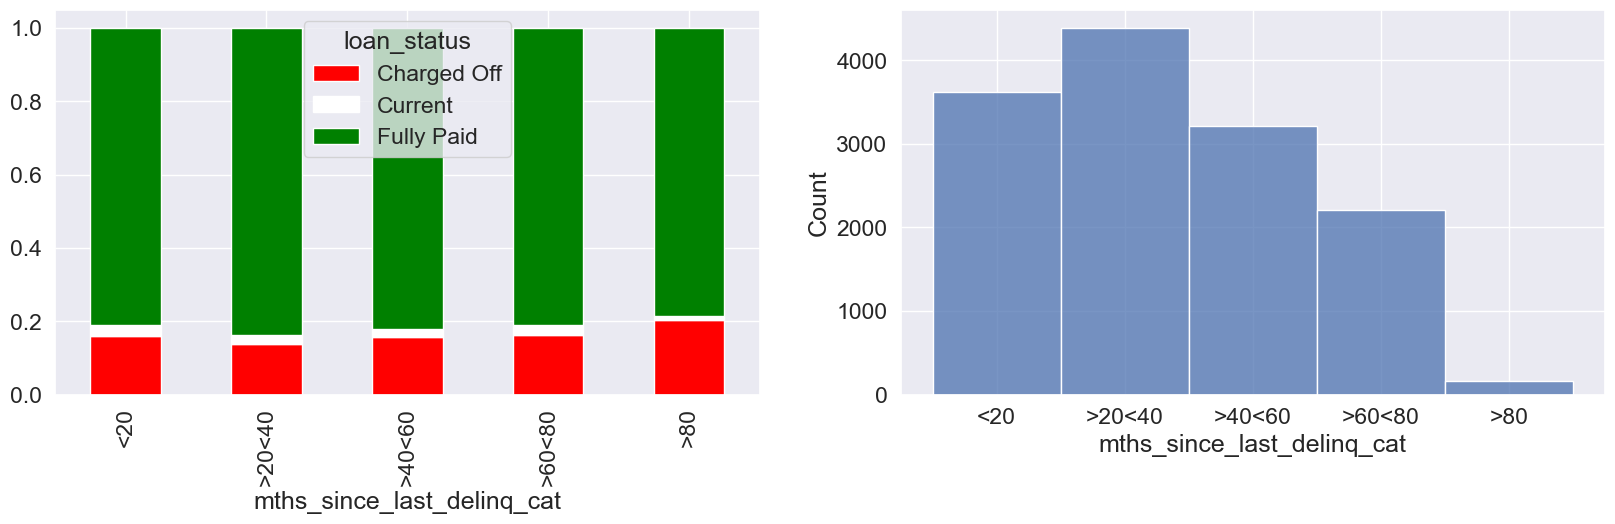

In [1544]:
LCLoanDf_ooc["mths_since_last_delinq_cat"]=pd.cut(LCLoanDf_ooc.mths_since_last_delinq,bins=[0,20,40,60,80,300],labels=['<20','>20<40','>40<60','>60<80','>80'])
LCLoanDf_ooc["mths_since_last_delinq_cat"].value_counts()
Tbl_Gen = pd.crosstab(LCLoanDf_ooc.loan_status, LCLoanDf_ooc["mths_since_last_delinq_cat"], margins=True,     values=LCLoanDf_ooc["loan_status"], aggfunc='count').round(2)
Tbl_Gen.loc["Prob_Def",:] = Tbl_Gen.loc["Charged Off",:]/Tbl_Gen.loc["All",:]
Tbl_Gen.iloc[4,:-1] = Tbl_Gen.iloc[4,:-1]/Tbl_Gen.iloc[4,:-1].sum()*Tbl_Gen.loc["Prob_Def","All"]
Tbl_Gen.loc["Prob_Def",:]  = Tbl_Gen.loc["Prob_Def",:].round(2)
Tbl_Gen = Tbl_Gen.fillna(0)
print(Tbl_Gen.head().round(2))
sb.set(font_scale=1.5)
Tbl_Gen_perc = Tbl_Gen.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_Gen_perc.plot(ax=axes[0],kind="bar", stacked="True",color=['red','white','green'])
sb.histplot(LCLoanDf_ooc.mths_since_last_delinq_cat,ax=axes[1],bins=20)
plt.show()

#### Correlation of All Numeric Variables with the Loan_Default 


In [1420]:
from pandas.core.indexes.interval import annotations
import plotly.express as px
LCLoanDf["loan_defaulted"] =  LCLoanDf.loan_status.apply(lambda x: 1 if (x=="Charged Off") else 0 )
LoanDfltCorr = LCLoanDf.corrwith(LCLoanDf.loan_defaulted)
sb.set(font_scale=1.5)
fig = px.area(data_frame=LoanDfltCorr,title='Correlation with loan_default')
fig.show()


In [ ]:
sb.reset_defaults